In [1]:
from slim_gsgp_lib_np.main_slim import slim
from slim_gsgp_lib_np.utils.utils import train_test_split
from slim_gsgp_lib_np.utils.callbacks import *
from slim_gsgp_lib_np.evaluators.fitness_functions import rmse
from slim_gsgp_lib_np.algorithms.SLIM_GSGP.operators.mutators import *
from slim_gsgp_lib_np.algorithms.SLIM_GSGP.operators.simplifiers import *
from slim_gsgp_lib_np.utils.utils import *
from slim_gsgp_lib_np.datasets.data_loader import *
from slim_gsgp_lib_np.algorithms.SLIM_GSGP.representations.population import Population
from slim_gsgp_lib_np.initializers.initializers import rhh, full, grow

import numpy as np
import pickle
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
from scipy.stats import percentileofscore
from functions.test_algorithms import *
from slim_gsgp_lib_np.selection.selection_algorithms import selector

datasets = [globals()[i] for i in globals() if 'load' in i][2:]

### For lexicase selection, it is better not to shuffle the cases! 

In [74]:
import random
import numpy as np
import timeit

# Dummy classes to simulate the Population and Individual structures.
class DummyIndividual:
    def __init__(self, id, num_cases):
        # Simulate error values for each test case.
        self.errors_case = np.random.rand(num_cases)

class DummyPopulation:
    def __init__(self, num_individuals, num_cases):
        # Create a list of dummy individuals.
        self.population = [DummyIndividual(i, num_cases) for i in range(num_individuals)]
        # Build a 2D array of errors (individuals x test cases).
        self.errors_case = np.array([ind.errors_case for ind in self.population])
        # Simulate fitness values.
        self.fit = np.random.rand(num_individuals)

# Set up parameters.
num_individuals = 100
num_cases = 1000
dummy_pop = DummyPopulation(num_individuals, num_cases)
targets = np.random.rand(num_cases)

# Old implementation: selects a random case in each iteration using random.randint.
def old_epsilon_lexicase_selection(targets, eps_fraction=1e-7, mode='min'):
    def els(pop):
        errors = pop.errors_case
        fitness_values = pop.fit
        fitness_std = np.std(fitness_values)
        epsilon = eps_fraction * fitness_std
        num_cases = targets.shape[0]
        pool = pop.population.copy()
        # Iterate for 5 cases, choosing a random case each time.
        for _ in range(5):
            case_idx = random.randint(0, num_cases - 1)
            case_errors = (errors[:, case_idx]) ** 2
            if mode == 'min':
                best_individuals = np.where(case_errors <= np.min(case_errors) + epsilon)[0]
            elif mode == 'max':
                best_individuals = np.where(case_errors >= np.max(case_errors) - epsilon)[0]
            if len(best_individuals) == 1:
                return pool[best_individuals[0]]
            pool = [pool[i] for i in best_individuals]
            errors = np.array([ind.errors_case for ind in pool])
        return random.choice(pool)
    return els

# Old implementation: selects a random case in each iteration using random.randint.
def lexicase_quantile_selection(targets, eps_fraction=1e-7, mode='min'):
    def els(pop):
        errors = pop.errors_case
        fitness_values = pop.fit
        # fitness_std = np.std(fitness_values)
        fitness_std = np.quantile(fitness_values, 0.1)
        epsilon = eps_fraction * fitness_std
        num_cases = targets.shape[0]
        pool = pop.population.copy()
        # Iterate for 5 cases, choosing a random case each time.
        for _ in range(5):
            case_idx = random.randint(0, num_cases - 1)
            case_errors = (errors[:, case_idx]) ** 2
            if mode == 'min':
                best_individuals = np.where(case_errors <= np.min(case_errors) + epsilon)[0]
            elif mode == 'max':
                best_individuals = np.where(case_errors >= np.max(case_errors) - epsilon)[0]
            if len(best_individuals) == 1:
                return pool[best_individuals[0]]
            pool = [pool[i] for i in best_individuals]
            errors = np.array([ind.errors_case for ind in pool])
        return random.choice(pool)
    return els

# Shuffled implementation: shuffles all cases once, then iterates over the first five.
def shuffled_epsilon_lexicase_selection(targets, eps_fraction=1e-7, mode='min'):
    def els(pop):
        errors = pop.errors_case
        fitness_values = pop.fit
        fitness_std = np.std(fitness_values)
        epsilon = eps_fraction * fitness_std
        num_cases = targets.shape[0]
        pool = pop.population.copy()
        # Generate a list of all test case indices and shuffle them.
        case_order = list(range(num_cases))
        random.shuffle(case_order)
        # Use the first 5 shuffled cases.
        for case_idx in case_order:
            case_errors = (errors[:, case_idx]) ** 2
            if mode == 'min':
                best_individuals = np.where(case_errors <= np.min(case_errors) + epsilon)[0]
            elif mode == 'max':
                best_individuals = np.where(case_errors >= np.max(case_errors) - epsilon)[0]
            if len(best_individuals) == 1:
                return pool[best_individuals[0]]
            pool = [pool[i] for i in best_individuals]
            errors = np.array([ind.errors_case for ind in pool])
        return random.choice(pool)
    return els

# Instantiate the selection functions.
old_selector = old_epsilon_lexicase_selection(targets, eps_fraction=1e-7, mode='min')
quantile_selector = lexicase_quantile_selection(targets, eps_fraction=1e-7, mode='min')
shuffled_selector = shuffled_epsilon_lexicase_selection(targets, eps_fraction=1e-7, mode='min')

# Benchmark each function using timeit.
repetitions = 10000
old_time = timeit.timeit(lambda: old_selector(dummy_pop), number=repetitions)
quantile_time = timeit.timeit(lambda: quantile_selector(dummy_pop), number=repetitions)
shuffled_time = timeit.timeit(lambda: shuffled_selector(dummy_pop), number=repetitions)

print("Old implementation total time over", repetitions, "runs:", old_time)
print("Quantile implementation total time over", repetitions, "runs:", quantile_time)
print("Shuffled implementation total time over", repetitions, "runs:", shuffled_time)


Old implementation total time over 10000 runs: 0.28326030005700886
Quantile implementation total time over 10000 runs: 0.7855577999725938
Shuffled implementation total time over 10000 runs: 3.001297599868849


### Experiments

In [2]:
seed = 100

# X = np.random.rand(442, 10) / 10
# y = 1500 * X[:, 0] + 1000 * X[:, 1]

# X,y = datasets[8]()
X,y = datasets[0]()

X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
# scaler_X, scaler_y = StandardScaler(), StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1)
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1)

tree, _ = slim(X_train=X_train, y_train=y_train, dataset_name='test', test_elite=False, slim_version='SLIM+ABS',
                    max_depth=17, init_depth=8, pop_size=100, n_iter=1, seed=seed, fitness_sharing=False, verbose=0,
                    p_inflate=0.45, p_struct=0.3, struct_mutation=False, full_return=True)

CONSTANTS, FUNCTIONS, TERMINALS = tree.collection[0].CONSTANTS, tree.collection[0].FUNCTIONS, tree.collection[0].TERMINALS

In [3]:
tree = tree.collection[0]

population = Population(
    [
        Individual(
            collection=[
                Tree(
                    tree,
                    train_semantics=None,
                    test_semantics=None,
                    reconstruct=True,
                )
            ],
            train_semantics=None,
            test_semantics=None,
            reconstruct=True,
        )
        for tree in grow(10000, 8, FUNCTIONS, TERMINALS, CONSTANTS, p_c=0.2, p_t=0.5)
    ]
)

# calculating initial population semantics
population.calculate_semantics(X_train)
population.calculate_errors_case(y_train)
population.evaluate(rmse, y=y_train, operator='sum')

preds_un = population.train_semantics
fitness_un = population.fit.copy()

# now for the scaled part
fitness_sc = []
preds_sc = []
fitness_sc_n = []
for ind in population.population:
    ind.version = 'SLIM+ABS'
    preds = ind.predict(X_train_scaled)
    fitness_sc_n.append(rmse(preds, y_train_scaled))
    # Reverse the scaling
    preds = scaler_y.inverse_transform(preds.reshape(-1,1)).reshape(-1)
    preds_sc.append(preds)
    fitness_sc.append(rmse(preds, y_train))

In [76]:
# Check how many of the fitnesses exceed 1000
theshold = 1000
print('Unscaled:', sum([1 for i in fitness_un if i > theshold]))
print('Scaled:', sum([1 for i in fitness_sc if i > theshold]))

Unscaled: 6367
Scaled: 4746


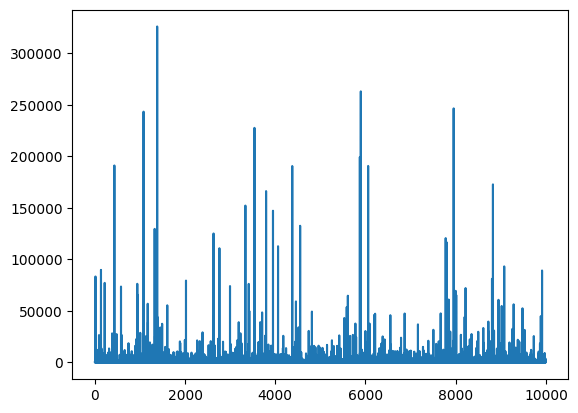

In [233]:
means_sc = [np.mean(np.abs(val)) for val in preds_sc]
plt.plot(means_sc)

In [237]:
m_sc, m_un = np.argmin(fitness_sc), np.argmin(fitness_un)

In [239]:
population.population[m_sc].structure

[(np.str_('multiply'),
  (np.str_('multiply'),
   (np.str_('add'), 'x2', 'x7'),
   (np.str_('multiply'), 'constant__0.9', 'x8')),
  (np.str_('subtract'),
   (np.str_('divide'), 'constant__0.33', 'x4'),
   (np.str_('divide'), 'x6', 'x9')))]

In [240]:
population.population[m_un].structure

[(np.str_('multiply'),
  (np.str_('divide'),
   (np.str_('divide'), 'constant__0.21', 'x7'),
   (np.str_('subtract'), 'x6', 'constant_0.29')),
  (np.str_('subtract'),
   (np.str_('add'), 'x6', 'x7'),
   (np.str_('subtract'), 'constant_0.64', 'x1')))]

In [221]:
# Find the max index of the max value of means_sc
max_index = np.argmax(means_sc)

In [222]:
population.population[max_index].structure

[(np.str_('divide'),
  (np.str_('divide'), 'constant_0.72', 'x2'),
  (np.str_('multiply'), 'x2', 'constant_0.13'))]

In [202]:
X_train_scaled

array([[0.0530303 , 0.21621622, 0.        , 0.        , 0.0091381 ],
       [0.01515152, 0.09009009, 0.72727273, 0.6010101 , 0.04713909],
       [0.30808081, 0.56756757, 0.45454545, 1.        , 0.82597324],
       ...,
       [0.03030303, 0.18018018, 0.72727273, 0.        , 0.08084723],
       [0.7979798 , 0.06756757, 1.        , 1.        , 0.05113905],
       [0.1489899 , 0.18918919, 0.09090909, 0.19949495, 0.01941383]])

In [203]:
# Find the max index of the max value of means_sc
max_index = np.argmax(fitness_un)

In [204]:
population.population[max_index].structure

[(np.str_('multiply'),
  (np.str_('divide'), 'x3', 'x4'),
  (np.str_('multiply'), 'x0', 'x0'))]

In [207]:
population.population[max_index].train_semantics

array([[1.56250000e+06, 4.42548441e+09, 5.85707190e+10, ...,
        3.98532220e+09, 5.42062014e+12, 2.57340738e+11]])

In [209]:
X_train

array([[1.25000e+03, 4.80000e+00, 2.54000e-02, 3.17000e+01, 9.30789e-04],
       [5.00000e+02, 2.00000e+00, 2.28600e-01, 5.55000e+01, 3.13525e-03],
       [6.30000e+03, 1.26000e+01, 1.52400e-01, 7.13000e+01, 4.83159e-02],
       ...,
       [8.00000e+02, 4.00000e+00, 2.28600e-01, 3.17000e+01, 5.09068e-03],
       [1.60000e+04, 1.50000e+00, 3.04800e-01, 7.13000e+01, 3.36729e-03],
       [3.15000e+03, 4.20000e+00, 5.08000e-02, 3.96000e+01, 1.52689e-03]])

In [205]:
fitness_sc[max_index]

np.float64(214.34719831258587)

In [206]:
fitness_un[max_index]

np.float64(294977458344.6206)

In [86]:
X_train_scaled[40]

array([0.00252525, 0.44594595, 0.45454545, 1.        , 0.32579239])

In [93]:
preds_sc[max_index][40]

np.float64(-985928696.7825208)

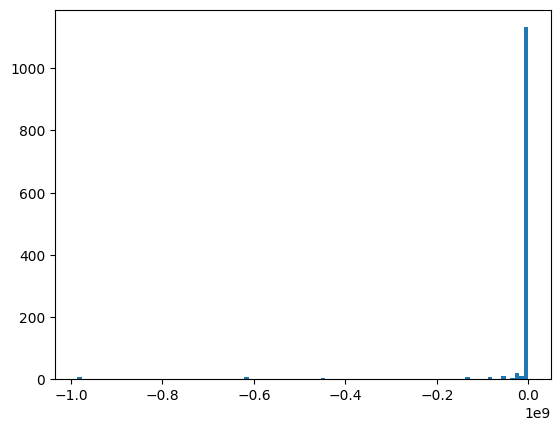

In [73]:
plt.hist(preds_sc[max_index], bins=100)
plt.show()

In [94]:
preds_sc[max_index]

array([ 2.67984000e+03,  1.40158000e+02, -9.68965812e+04, ...,
       -3.11404591e+09,  1.40158000e+02, -6.30122281e+03])

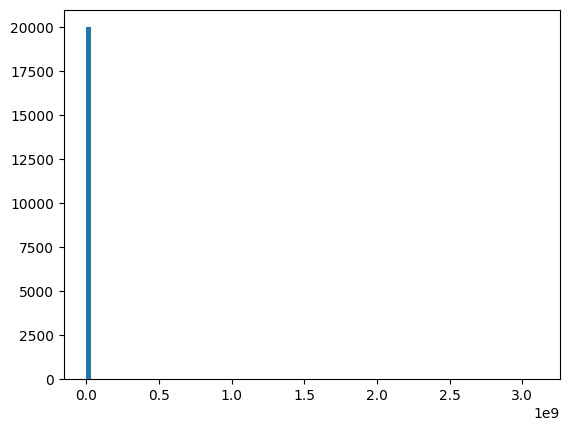

In [184]:
plt.hist(fitness_sc, bins=100)
plt.show()

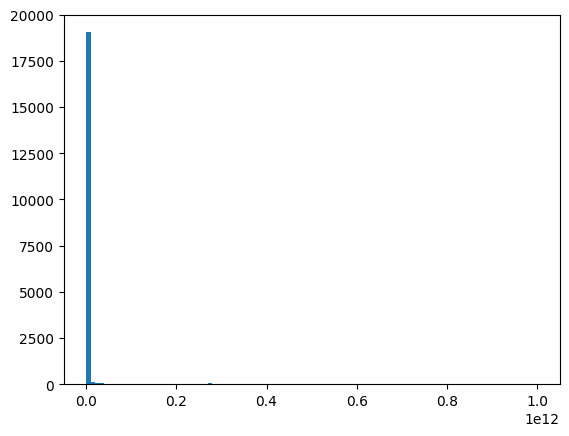

In [183]:
plt.hist(fitness_un, bins=100)
plt.show()

In [182]:
print(np.mean(fitness_un), np.mean(fitness_sc))
print(np.std(fitness_un), np.std(fitness_sc))
print(np.mean(fitness_un) / np.mean(fitness_sc))  

13856390642.30934 405322.0521689327
85529714314.59909 24453392.055817347
34186.125744113684


In [4]:
print(np.mean(fitness_un), np.mean(fitness_sc))
print(np.std(fitness_un), np.std(fitness_sc))
print(np.mean(fitness_un) / np.mean(fitness_sc))  

27428947655.665825 473449019.05676556
135682297094.99112 22522504355.654175
57.93432144037698


In [12]:
print(np.mean(fitness_un), np.mean(fitness_sc))
print(np.std(fitness_un), np.std(fitness_sc))
print(np.mean(fitness_un) / np.mean(fitness_sc))  

27425552462.67228 494619823.3514793
135669113808.67506 23297650735.76005
55.4477422211676


In [165]:
print(np.mean(fitness_un), np.mean(fitness_sc))
print(np.std(fitness_un), np.std(fitness_sc))
print(np.mean(fitness_un) / np.mean(fitness_sc))  

29100498201.848927 436446859.37375265
140583790584.81927 24695392656.463497
66.67592532022007


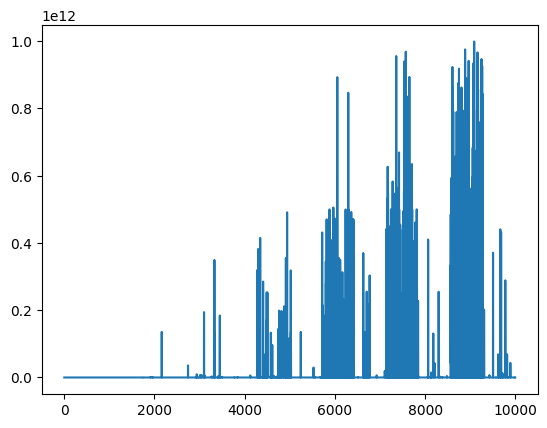

In [159]:
# Plot the ratios moving average
ma_ratio = np.convolve(fitness_un, np.ones(2)/2, mode='valid')
plt.plot(ma_ratio)
plt.show()

### How much does the depth distribution change with the probability of terminal? 

Answer: a lot ! 

In [ ]:
# Make p_t from 0.5 to 0.95 from 0.05 increments 
p_ts = np.arange(0.5, 0.95, 0.1)
results = {}

for p_t in p_ts:
    population = Population(
        [
            Individual(
                collection=[
                    Tree(
                        tree,
                        train_semantics=None,
                        test_semantics=None,
                        reconstruct=True,
                    )
                ],
                train_semantics=None,
                test_semantics=None,
                reconstruct=True,
            )
            for tree in grow(10000, 8, FUNCTIONS, TERMINALS, CONSTANTS, p_c=0.2, p_t=p_t)
        ]
    )

    depths = [ind.collection[0].depth for ind in population.population]
    results[round(p_t,2)] = depths

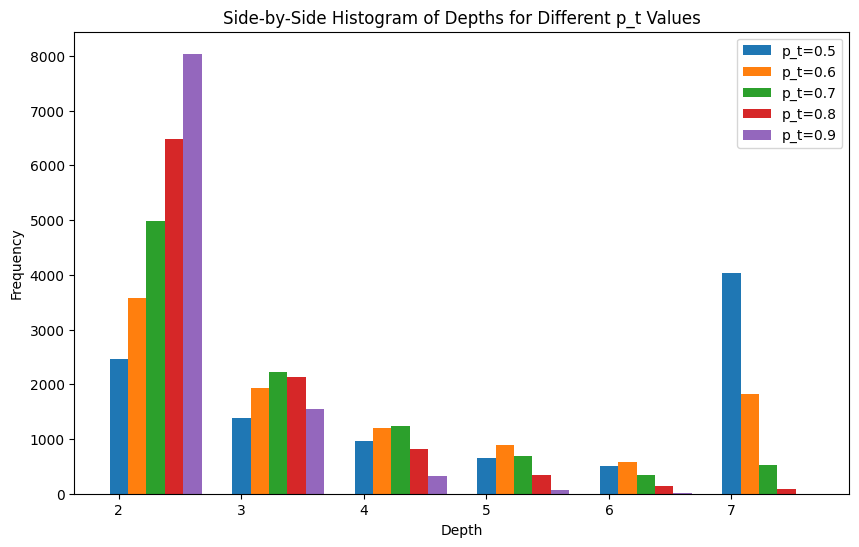

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define bin edges
bins = np.arange(2, 9, 1)  # Adjust bins as needed

# Define bar width
bar_width = 0.15

# Create figure
plt.figure(figsize=(10, 6))

# Loop through results and plot each histogram with offset bins
for i, (p_t, depths) in enumerate(results.items()):
    # Offset bins for each group
    offset_bins = bins[:-1] + i * bar_width
    plt.bar(offset_bins, np.histogram(depths, bins=bins)[0], 
            width=bar_width, label=f"p_t={p_t}")

# Add labels and legend
plt.xlabel("Depth")
plt.ylabel("Frequency")
plt.title("Side-by-Side Histogram of Depths for Different p_t Values")
plt.legend()
plt.show()


### What makes scaling work and not work, depending on the problem?

Scaling doesnt work always. 

In [ ]:
results = pd.DataFrame(columns=['Unscaled (2)', 'Scaled (2)', 'Unscaled (3)', 'Scaled (3)', 'Unscaled (4)', 'Scaled (4)', 'Unscaled (5)', 'Scaled (5)',  'Unscaled_q1'])
for i in range(16): 
    X,y = datasets[i]()
    X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    # scaler_X, scaler_y = StandardScaler(), StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1)
    tree, _ = slim(X_train=X_train, y_train=y_train, dataset_name='test', test_elite=False, slim_version='SLIM+ABS',
                        max_depth=17, init_depth=8, pop_size=100, n_iter=1, seed=seed, fitness_sharing=False, verbose=0,
                        p_inflate=0.45, p_struct=0.3, struct_mutation=False, full_return=True)
    tree = tree.collection[0]
    CONSTANTS, FUNCTIONS, TERMINALS = tree.CONSTANTS, tree.FUNCTIONS, tree.TERMINALS

    population = Population(
        [
            Individual(
                collection=[
                    Tree(
                        tree,
                        train_semantics=None,
                        test_semantics=None,
                        reconstruct=True,
                    )
                ],
                train_semantics=None,
                test_semantics=None,
                reconstruct=True,
            )
            for tree in grow(10000, 8, FUNCTIONS, TERMINALS, CONSTANTS, p_c=0.2, p_t=0.75)
        ]
    )

    # calculating initial population semantics
    population.calculate_semantics(X_train)
    population.calculate_errors_case(y_train)
    population.evaluate(rmse, y=y_train, operator='sum')

    preds_un = population.train_semantics
    fitness_un = population.fit.copy()

    # now for the scaled part
    fitness_sc = []
    preds_sc = []
    fitness_sc_n = []
    for ind in population.population:
        ind.version = 'SLIM+ABS'
        preds = ind.predict(X_train_scaled)
        fitness_sc_n.append(rmse(preds, y_train_scaled))
        # Reverse the scaling
        preds = scaler_y.inverse_transform(preds.reshape(-1,1)).reshape(-1)
        preds_sc.append(preds)
        fitness_sc.append(rmse(preds, y_train))
    
    data1, data2 = percentileofscore(fitness_un, np.quantile(fitness_un, 0.01)*2), percentileofscore(fitness_sc, np.quantile(fitness_un, 0.01)*2)
    data3, data4 = percentileofscore(fitness_un, np.quantile(fitness_un, 0.01)*3), percentileofscore(fitness_sc, np.quantile(fitness_un, 0.01)*3)
    data5, data6 = percentileofscore(fitness_un, np.quantile(fitness_un, 0.01)*4), percentileofscore(fitness_sc, np.quantile(fitness_un, 0.01)*4)
    data7, data8 = percentileofscore(fitness_un, np.quantile(fitness_un, 0.01)*5), percentileofscore(fitness_sc, np.quantile(fitness_un, 0.01)*5)
    data9 = np.quantile(fitness_un, 0.01)
    temp = [data1, data2, data3, data4, data5, data6, data7, data8, data9]
    results.loc[i] = temp

for i in range(4):
    results[f'Ratio ({i+2})'] = results[f'Unscaled ({i+2})'] / results[f'Scaled ({i+2})']   

In [ ]:
results

,Unscaled (2),Scaled (2),Unscaled (3),Scaled (3),Unscaled (4),Scaled (4),Unscaled (5),Scaled (5),Unscaled_q1,Ratio (2),Ratio (3),Ratio (4),Ratio (5)
0,10.22,21.97,38.71,37.19,40.52,49.79,41.31,59.16,132.784102,0.465180,1.040871,0.813818,0.698276
1,48.11,4.31,51.87,11.96,52.56,24.75,53.05,30.45,0.015414,11.162413,4.336957,2.123636,1.742200
2,56.90,85.62,66.69,87.52,67.99,88.69,68.35,89.21,62.944913,0.664564,0.761997,0.766603,0.766170
3,4.44,2.40,6.67,11.64,12.92,27.32,92.11,47.24,1103.902803,1.850000,0.573024,0.472914,1.949831
4,17.63,32.60,54.74,53.86,59.57,65.72,61.47,72.60,11.028191,0.540798,1.016339,0.906421,0.846694
5,41.52,64.56,47.92,76.48,50.73,80.70,52.32,83.14,0.485318,0.643123,0.626569,0.628625,0.629300
6,26.86,58.65,28.27,71.50,28.89,76.08,29.32,78.86,13.256269,0.457971,0.395385,0.379732,0.371798
7,28.15,61.76,33.46,73.23,39.01,78.46,44.26,81.93,30.691217,0.455797,0.456917,0.497196,0.540217
8,98.39,72.57,98.71,81.45,98.93,86.64,99.04,89.68,171.450626,1.355794,1.211909,1.141851,1.104371
9,41.19,38.50,52.70,65.78,53.52,76.39,54.08,82.54,12.351435,1.069870,0.801155,0.700615,0.655197


In [ ]:
results[[f'Ratio ({i})' for i in range(2,6)]].style.background_gradient(cmap='coolwarm')

,Ratio (2),Ratio (3),Ratio (4),Ratio (5)
0,0.465180,1.040871,0.813818,0.698276
1,11.162413,4.336957,2.123636,1.742200
2,0.664564,0.761997,0.766603,0.766170
3,1.850000,0.573024,0.472914,1.949831
4,0.540798,1.016339,0.906421,0.846694
5,0.643123,0.626569,0.628625,0.629300
6,0.457971,0.395385,0.379732,0.371798
7,0.455797,0.456917,0.497196,0.540217
8,1.355794,1.211909,1.141851,1.104371
9,1.069870,0.801155,0.700615,0.655197


### Fitness distributions for scaled and unscaled problems

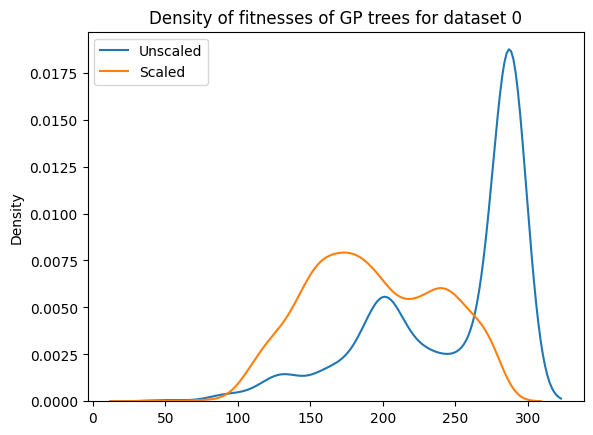

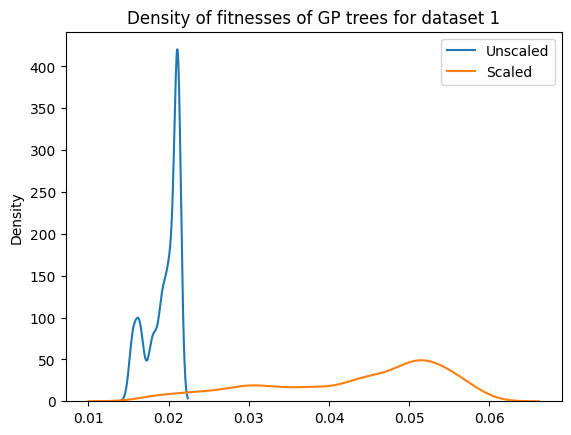

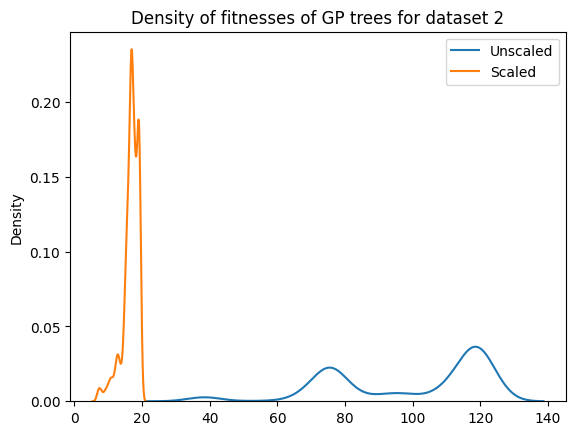

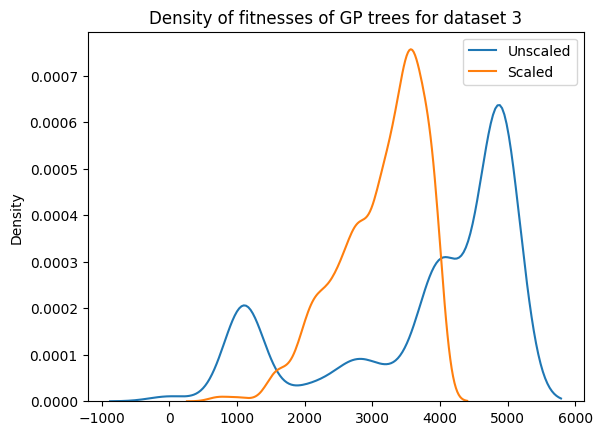

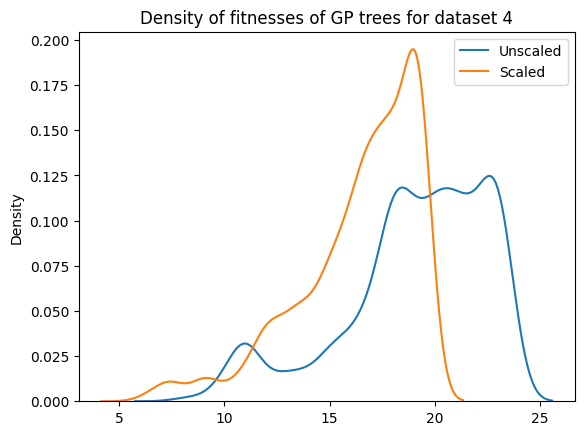

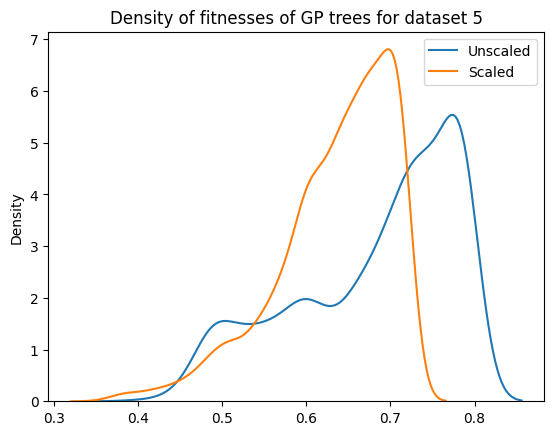

KeyboardInterrupt: 

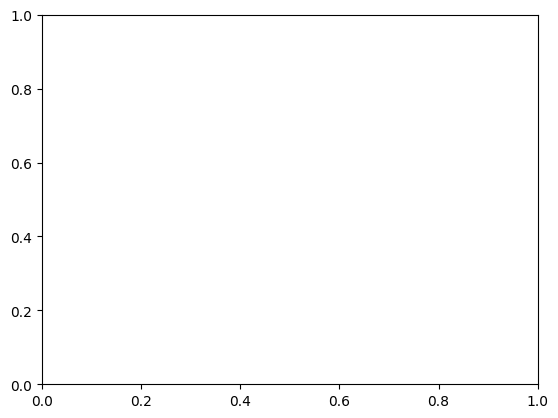

In [178]:
for i in range(16):
    X,y = datasets[i]()
    X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1)
    tree, _ = slim(X_train=X_train, y_train=y_train, dataset_name='test', test_elite=False, slim_version='SLIM+ABS',
                        max_depth=17, init_depth=8, pop_size=100, n_iter=1, seed=seed, fitness_sharing=False, verbose=0,
                        p_inflate=0.45, p_struct=0.3, struct_mutation=False, full_return=True)

    tree = tree.collection[0]
    CONSTANTS, FUNCTIONS, TERMINALS = tree.CONSTANTS, tree.FUNCTIONS, tree.TERMINALS

    population = Population(
        [
            Individual(
                collection=[
                    Tree(
                        tree,
                        train_semantics=None,
                        test_semantics=None,
                        reconstruct=True,
                    )
                ],
                train_semantics=None,
                test_semantics=None,
                reconstruct=True,
            )
            for tree in grow(10000, 8, FUNCTIONS, TERMINALS, CONSTANTS, p_c=0.2, p_t=0.8)
        ]
    )

    # calculating initial population semantics
    population.calculate_semantics(X_train)
    population.calculate_errors_case(y_train)
    population.evaluate(rmse, y=y_train, operator='sum')

    preds_un = population.train_semantics
    fitness_un = population.fit.copy()

    # now for the scaled part
    fitness_sc = []
    preds_sc = []
    fitness_sc_n = []
    for ind in population.population:
        ind.version = 'SLIM+ABS'
        preds = ind.predict(X_train_scaled)
        fitness_sc_n.append(rmse(preds, y_train_scaled))
        # Reverse the scaling
        preds = scaler_y.inverse_transform(preds.reshape(-1,1)).reshape(-1)
        preds_sc.append(preds)
        fitness_sc.append(rmse(preds, y_train))

    # Plot the fitness distributions overlaid
    threshold_un = np.quantile(fitness_un, 0.25)
    threshold_sc = np.quantile(fitness_sc, 0.25)
    fitness_un_no = [i for i in fitness_un if i < threshold_un]
    fitness_sc_no = [i for i in fitness_sc if i < threshold_sc]
    sns.kdeplot(fitness_un_no, label='Unscaled')
    sns.kdeplot(fitness_sc_no, label='Scaled')
    plt.title(f'Density of fitnesses of GP trees for dataset {i}')
    plt.legend()
    plt.show()

### How much does structure mutation change the semantics of GP trees? 

In [ ]:
population = Population(
    [
        Individual(
            collection=[
                Tree(
                    tree,
                    train_semantics=None,
                    test_semantics=None,
                    reconstruct=True,
                )
            ],
            train_semantics=None,
            test_semantics=None,
            reconstruct=True,
        )
        for tree in rhh(10000, 8, FUNCTIONS, TERMINALS, CONSTANTS, p_c=0.2, p_t=0.8)
    ]
)

In [601]:
def get_preds_and_fitness(pop, X_train_scaled, scaler_y, y_train, version='SLIM+ABS'):
    """
    For each individual in the population, set its version, compute predictions on scaled data,
    inverse-transform the predictions, and compute the RMSE fitness.
    """
    preds_list, fitness_list = [], []
    for ind in pop.population:
        ind.version = version
        preds = ind.predict(X_train_scaled)
        preds = scaler_y.inverse_transform(preds.reshape(-1, 1)).reshape(-1)
        preds_list.append(preds)
        fitness_list.append(rmse(preds, y_train))
    return preds_list, fitness_list

def run_mutation_experiment(dataset_idx, 
                            n=5000,
                            num_mutations=1,
                            p_t=0.8,
                            p_c=0.2,
                            depth_dist='exp',
                            decay_rate=0.2, 
                            selector=None,
                            seed=42):
    """
    Runs the experiment:
      1. Loads a dataset and splits it.
      2. Scales the features and target.
      3. Obtains an initial tree via slim.
      4. Generates a population using the 'grow' function.
      5. Evaluates the original population.
      6. Applies structure mutations (num_mutations times per individual).
      7. Evaluates the mutated (offspring) population.
    
    Returns a dictionary containing fitness, predictions, the original population,
    and the mutated population.
    """
    # 1. Load data and split
    X, y = datasets[dataset_idx]()
    X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)
    
    # 2. Scale data
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
    
    # 3. Get base tree using slim
    base_tree, _ = slim(
        X_train=X_train, y_train=y_train, dataset_name='test', test_elite=False,
        slim_version='SLIM+ABS', max_depth=17, init_depth=8, pop_size=100, n_iter=1,
        seed=seed, fitness_sharing=False, verbose=0, p_inflate=0.45, p_struct=0.3,
        struct_mutation=False, full_return=True
    )
    base_tree = base_tree.collection[0]
    CONSTANTS, FUNCTIONS, TERMINALS = base_tree.CONSTANTS, base_tree.FUNCTIONS, base_tree.TERMINALS
    
    # 4. Generate initial population using the 'grow' function
    population = Population(
        [Individual(collection=[Tree(tree,train_semantics=None,test_semantics=None,reconstruct=True,)],
                    train_semantics=None,test_semantics=None,reconstruct=True,)
            for tree in rhh(n, 8, FUNCTIONS, TERMINALS, CONSTANTS, p_c=p_c, p_t=p_t)
        ]
    )    
    # Create a structure mutator for later use.
    mutator = structure_mutation(FUNCTIONS=FUNCTIONS, TERMINALS=TERMINALS, CONSTANTS=CONSTANTS, depth_dist=depth_dist)
    
    # 5. Evaluate original population
    population.calculate_semantics(X_train)
    population.calculate_errors_case(y_train)
    population.evaluate(rmse, y=y_train, operator='sum')
    
    original_preds, original_fitness = get_preds_and_fitness(population, X_train_scaled, scaler_y, y_train)

    # 6. For each individual, apply the structure mutation num_mutations times
    if selector is not None:
        for _ in range(num_mutations):
            mutated_individuals = []
            # elite = population.population[np.argmin(population.fit)]
            # mutated_individuals.append(elite)
            for i in range(len(population.population)-2):
                selected_ind = selector(population)
                mutated_ind = mutator(
                    individual=selected_ind, X=X_train, max_depth=8,
                    p_c=p_c, p_t=p_t, grow_probability=1, decay_rate=decay_rate
                )
                mutated_individuals.append(mutated_ind)
            offspring_population = Population(mutated_individuals)
            offspring_population.calculate_semantics(X_train)
            offspring_population.calculate_errors_case(y_train)
            offspring_population.evaluate(rmse, y=y_train, operator
            ='sum')

    else:
        mutated_individuals = []
        for ind in population.population:
            mutated_ind = ind
            for _ in range(num_mutations):
                mutated_ind = mutator(
                    individual=mutated_ind, X=X_train, max_depth=8,
                    p_c=p_c, p_t=p_t, grow_probability=1, decay_rate=decay_rate
                )
            mutated_individuals.append(mutated_ind)

        offspring_population = Population(mutated_individuals)
        offspring_population.calculate_semantics(X_train)
        offspring_population.calculate_errors_case(y_train)
        offspring_population.evaluate(rmse, y=y_train, operator='sum')
    
    mutated_preds, mutated_fitness = get_preds_and_fitness(offspring_population, X_train_scaled, scaler_y, y_train)
    
    # 7. Return results
    return {
        'original': {
            'fit_un': population.fit,
            'fit_sc': original_fitness,
            'depths': [ind.collection[0].depth for ind in population.population],
            'pop': population
        },
        'mutated': {
            'fit_un': offspring_population.fit,
            'fit_sc': mutated_fitness,
            'depths': [ind.collection[0].depth for ind in offspring_population.population],
            'pop': offspring_population
        },
        'scalers': {'X': scaler_X, 'y': scaler_y},
        'data': {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}
    }

In [599]:
results = run_mutation_experiment(dataset_idx=0, n=500, num_mutations=1, p_t=0.8, p_c=0.2, depth_dist='exp', decay_rate=0.05, seed=42)

In [600]:
# Calculate the mean distance between the original and mutated trees semantics
original = results['original']['pop'] 
offs = results['mutated']['pop']
sem_original = original.train_semantics
sem_mutated = offs.train_semantics
np.mean([np.linalg.norm(sem_original[i] - sem_mutated[i]) for i in range(len(sem_original))])

np.float64(3851272954366.1226)

In [575]:
# Calculate the mean distance between the original and mutated trees semantics
original = results['original']['population'] 
offs = results['mutated']['population']
sem_original = original.train_semantics
sem_mutated = offs.train_semantics
np.mean([np.linalg.norm(sem_original[i] - sem_mutated[i]) for i in range(len(sem_original))])

np.float64(4445581905267.244)

In [587]:
[np.linalg.norm(sem_original[i] - sem_mutated[i]) for i in range(len(sem_original))][17]

np.float64(9.323113414514934)

In [584]:
3851272954366.1226/2230781326717.456

1.7264233424587532

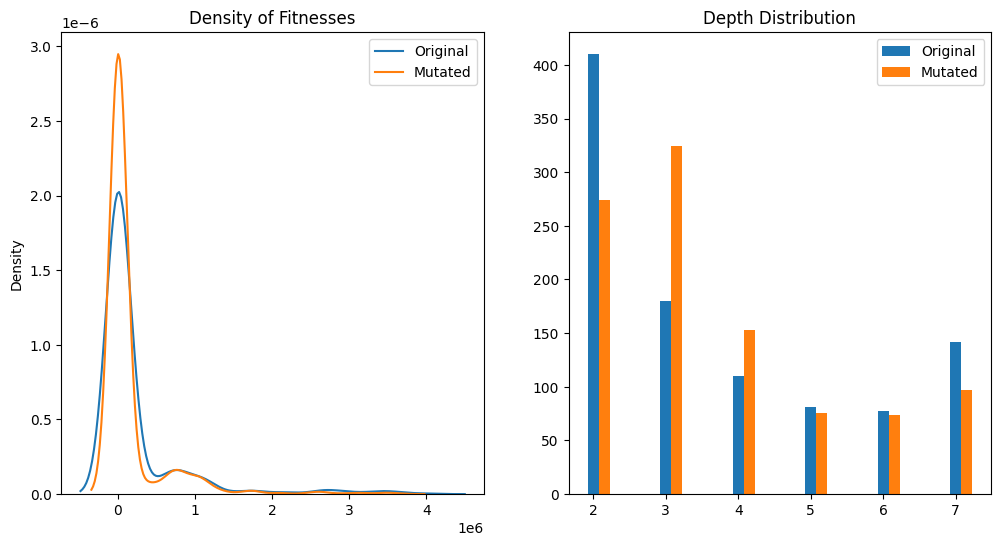

In [604]:
selecting = selector(type='tournament', pool_size=2)
results = run_mutation_experiment(dataset_idx=0, n=1000, num_mutations=10, p_t=0.8, p_c=0.2, depth_dist='diz', decay_rate=0.2, seed=42, selector=selecting)
original_fitness = results['original']['fit_un']
mutated_fitness = results['mutated']['fit_un']
original_depths = results['original']['depths']
mutated_depths = results['mutated']['depths']

crop = np.quantile(original_fitness,0.75)
original_no_outliers = [original_fitness[i] for i in range(len(original_fitness)) if original_fitness[i] < crop]
mutated_no_outliers = [mutated_fitness[i] for i in range(len(mutated_fitness)) if mutated_fitness[i] < crop]

fix, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(original_no_outliers, ax=ax[0], label='Original')
sns.kdeplot(mutated_no_outliers, ax=ax[0], label='Mutated')
ax[0].set_title('Density of Fitnesses')
ax[0].legend()
# Histograms
# bins = np.arange(0, crop, crop/50)
# bar_width = crop/150
# offset_bins = bins[:-1] + 0 * bar_width
# ax[0].bar(offset_bins, np.histogram(original_no_outliers, bins=bins)[0], width=bar_width, label='Original')
# offset_bins = bins[:-1] + 1 * bar_width
# ax[0].bar(offset_bins, np.histogram(mutated_no_outliers, bins=bins)[0], width=bar_width, label='Mutated')
# ax[0].set_title('Fitness Distribution')
# ax[0].legend()

bins = np.arange(2, 9, 1)
bar_width = 0.15
offset_bins = bins[:-1] + 0 * bar_width
ax[1].bar(offset_bins, np.histogram(original_depths, bins=bins)[0], width=bar_width, label='Original')
offset_bins = bins[:-1] + 1 * bar_width
ax[1].bar(offset_bins, np.histogram(mutated_depths, bins=bins)[0], width=bar_width, label='Mutated')
ax[1].set_title('Depth Distribution')       
ax[1].legend()
plt.show()

In [578]:
results = run_mutation_experiment(0, num_mutations=10, p_t=0.8, p_c=0.2, depth_dist='exp', decay_rate=0.1, seed=42)
original_fitness = results['original']['fitness']
mutated_fitness = results['mutated']['fitness']
original_depths = results['original']['depths']
mutated_depths = results['mutated']['depths']

original_no_outliers = [original_fitness[i] for i in range(len(original_fitness)) if original_fitness[i] < 2000]
mutated_no_outliers = [mutated_fitness[i] for i in range(len(mutated_fitness)) if mutated_fitness[i] < 2000]

fix, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.kdeplot(original_no_outliers, ax=ax[0], label='Original')
sns.kdeplot(mutated_no_outliers, ax=ax[0], label='Mutated')
ax[0].set_title('Fitness Density')
ax[0].legend()

bins = np.arange(2, 9, 1)
bar_width = 0.15
offset_bins = bins[:-1] + 0 * bar_width
ax[1].bar(offset_bins, np.histogram(original_depths, bins=bins)[0], width=bar_width, label='Original')
offset_bins = bins[:-1] + 1 * bar_width
ax[1].bar(offset_bins, np.histogram(mutated_depths, bins=bins)[0], width=bar_width, label='Mutated')
ax[1].set_title('Depth Distribution')
ax[1].legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
X,y = datasets[0]()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1)
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1)
tree, _ = slim(X_train=X_train, y_train=y_train, dataset_name='test', test_elite=False, slim_version='SLIM+ABS',
                    max_depth=17, init_depth=8, pop_size=100, n_iter=1, seed=seed, fitness_sharing=False, verbose=0,
                    p_inflate=0.45, p_struct=0.3, struct_mutation=False, full_return=True)

tree = tree.collection[0]
CONSTANTS, FUNCTIONS, TERMINALS = tree.CONSTANTS, tree.FUNCTIONS, tree.TERMINALS

population = Population(
    [
        Individual(
            collection=[
                Tree(
                    tree,
                    train_semantics=None,
                    test_semantics=None,
                    reconstruct=True,
                )
            ],
            train_semantics=None,
            test_semantics=None,
            reconstruct=True,
        )
        for tree in grow(10000, 8, FUNCTIONS, TERMINALS, CONSTANTS, p_c=0.2, p_t=0.8)
    ]
)
structure_mutator = structure_mutation(FUNCTIONS=FUNCTIONS, TERMINALS=TERMINALS, CONSTANTS=CONSTANTS, depth_dist='exp')

population.calculate_semantics(X_train)
population.calculate_errors_case(y_train)
population.evaluate(rmse, y=y_train, operator='sum')

preds_un = population.train_semantics
fitness_un = population.fit.copy()
fitness_sc, preds_sc, offs_pop = [], [], []
for ind in population.population:
    ind.version = 'SLIM+ABS'
    preds = ind.predict(X_train_scaled)
    preds = scaler_y.inverse_transform(preds.reshape(-1,1)).reshape(-1)
    preds_sc.append(preds)
    fitness_sc.append(rmse(preds, y_train))
    
    # Mutate the structure
    ind_mutated = structure_mutator(individual=ind, X=X_train, max_depth=8, p_c=0.2, grow_probability=1, decay_rate=0.2)
    offs_pop.append(ind_mutated)

offs_pop = Population(offs_pop)
offs_pop.calculate_semantics(X_train)
offs_pop.calculate_errors_case(y_train)
offs_pop.evaluate(rmse, y=y_train, operator='sum')

preds_un = population.train_semantics
fitness_un_offs = population.fit.copy()
fitness_sc_offs, preds_sc_offs = [], []
for ind in offs_pop.population:
    ind.version = 'SLIM+ABS'
    preds = ind.predict(X_train_scaled)
    preds = scaler_y.inverse_transform(preds.reshape(-1,1)).reshape(-1)
    preds_sc_offs.append(preds)
    fitness_sc_offs.append(rmse(preds, y_train))

In [ ]:
sampled_fit_norm, sampled_fit_div, sampled_fit_exp, sampled_fit_uni = [], [], [], []
structure_mutator_norm = structure_mutation(FUNCTIONS=FUNCTIONS, TERMINALS=TERMINALS, CONSTANTS=CONSTANTS, depth_dist='norm')
strucutre_mutator_div = structure_mutation(FUNCTIONS=FUNCTIONS, TERMINALS=TERMINALS, CONSTANTS=CONSTANTS, depth_dist='div')
structure_mutator_exp = structure_mutation(FUNCTIONS=FUNCTIONS, TERMINALS=TERMINALS, CONSTANTS=CONSTANTS, depth_dist='exp')
structure_mutator_uni = structure_mutation(FUNCTIONS=FUNCTIONS, TERMINALS=TERMINALS, CONSTANTS=CONSTANTS, depth_dist='uniform')

for i in range(10000):
    mut_norm = structure_mutator_norm(individual=population.population[0], X=X_train, max_depth=8, p_c=0.2, grow_probability=1, decay_rate=0.2)
    mut_div = strucutre_mutator_div(individual=population.population[0], X=X_train, max_depth=8, p_c=0.2, grow_probability=1, decay_rate=0.2)
    mut_exp = structure_mutator_exp(individual=population.population[0], X=X_train, max_depth=8, p_c=0.2, grow_probability=1, decay_rate=0.2)
    mut_uni = structure_mutator_uni(individual=population.population[0], X=X_train, max_depth=8, p_c=0.2, grow_probability=1, decay_rate=0.2)

    mut_norm.evaluate(rmse, y=y_train, operator='sum')
    mut_div.evaluate(rmse, y=y_train, operator='sum')
    mut_exp.evaluate(rmse, y=y_train, operator='sum')
    mut_uni.evaluate(rmse, y=y_train, operator='sum')

    sampled_fit_norm.append(mut_norm.fitness)
    sampled_fit_div.append(mut_div.fitness)
    sampled_fit_exp.append(mut_exp.fitness)
    sampled_fit_uni.append(mut_uni.fitness)

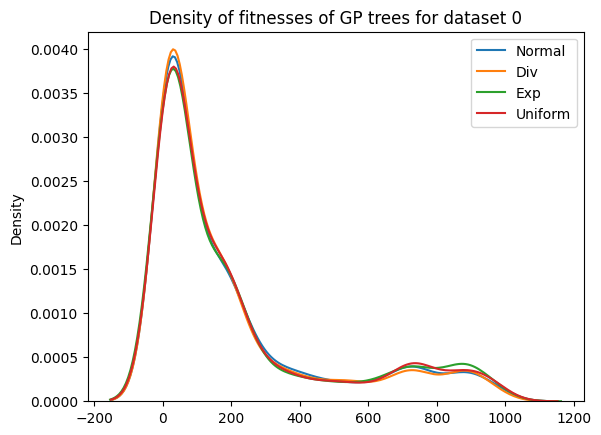

In [ ]:
sampled_fit_norm_no = [i for i in sampled_fit_norm if i < 1000]
sampled_fit_div_no = [i for i in sampled_fit_div if i < 1000]
sampled_fit_exp_no = [i for i in sampled_fit_exp if i < 1000]
sampled_fit_uni_no = [i for i in sampled_fit_uni if i < 1000]
sns.kdeplot(sampled_fit_norm_no, label='Normal')
sns.kdeplot(sampled_fit_div_no, label='Div')
sns.kdeplot(sampled_fit_exp_no, label='Exp')
sns.kdeplot(sampled_fit_uni_no, label='Uniform')
plt.title('Density of fitnesses of GP trees for dataset 0')
plt.legend()
plt.show()

### How much does structure mutation change the semantics of GP trees?  II

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# A simple Node class for arithmetic expressions
class Node:
    def __init__(self, op, left=None, right=None):
        self.op = op        # operator or terminal ('x' or constant)
        self.left = left
        self.right = right
    
    def evaluate(self, x):
        # x is expected to be a numpy array
        if self.op == 'x':
            return x
        elif isinstance(self.op, (int, float)):
            # return a constant (vectorized to match x)
            return np.full_like(x, self.op, dtype=float)
        elif self.op == '+':
            return self.left.evaluate(x) + self.right.evaluate(x)
        elif self.op == '-':
            return self.left.evaluate(x) - self.right.evaluate(x)
        elif self.op == '*':
            return self.left.evaluate(x) * self.right.evaluate(x)
        else:
            raise ValueError("Unknown operator: " + str(self.op))
    
    def __str__(self):
        if self.left is None and self.right is None:
            return str(self.op)
        return f"({self.left} {self.op} {self.right})"

# Random tree generator: builds a tree up to a maximum depth.
def generate_random_tree(max_depth, current_depth=0):
    if current_depth >= max_depth:
        # Terminal node: either the variable 'x' or a random constant.
        return Node('x') if random.random() < 0.5 else Node(random.randint(1, 10))
    else:
        # Occasionally produce a terminal before reaching max_depth.
        if random.random() < 0.3:
            return Node('x') if random.random() < 0.5 else Node(random.randint(1, 10))
        op = random.choice(['+', '-', '*'])
        left = generate_random_tree(max_depth, current_depth+1)
        right = generate_random_tree(max_depth, current_depth+1)
        return Node(op, left, right)

# Get a list of all nodes with their depth and a "path" to locate them.
def get_nodes_with_depths(node, current_depth=0, path=None):
    if path is None:
        path = []
    nodes = [(node, current_depth, path)]
    if node.left is not None:
        nodes += get_nodes_with_depths(node.left, current_depth+1, path + ['L'])
    if node.right is not None:
        nodes += get_nodes_with_depths(node.right, current_depth+1, path + ['R'])
    return nodes

# A simple recursive copy function to duplicate a tree.
def copy_tree(node):
    if node is None:
        return None
    new_node = Node(node.op)
    new_node.left = copy_tree(node.left)
    new_node.right = copy_tree(node.right)
    return new_node

# Replace a subtree at the given path with a new subtree.
def replace_subtree(root, path, new_subtree):
    if not path:
        return new_subtree
    current = root
    for direction in path[:-1]:
        current = current.left if direction == 'L' else current.right
    if path[-1] == 'L':
        current.left = new_subtree
    else:
        current.right = new_subtree
    return root

# Define semantic difference as the average absolute difference between outputs.
def semantic_difference(original_tree, mutated_tree, x_values):
    orig_vals = original_tree.evaluate(x_values)
    mutated_vals = mutated_tree.evaluate(x_values)
    return np.mean(np.abs(orig_vals - mutated_vals))

# Simulation: For a given base tree, try mutations at various depths with various inserted subtree sizes.
def test_mutation_impact(num_trees=50):
    results = []
    # Evaluate over a range of x-values.
    x_values = np.linspace(-10, 10, 200)
    for _ in range(num_trees):
        base_tree = generate_random_tree(max_depth=7)
        print(base_tree)
        nodes = get_nodes_with_depths(base_tree)
        for node, mutation_depth, path in nodes:
            # Try different sizes (max depth) for the inserted mutation subtree.
            for inserted_tree_depth in [1, 2, 3, 4, 5, 6]:
                tree_copy = copy_tree(base_tree)
                new_subtree = generate_random_tree(max_depth=inserted_tree_depth)
                mutated_tree = replace_subtree(tree_copy, path, new_subtree)
                diff = semantic_difference(base_tree, mutated_tree, x_values)
                results.append({
                    'mutation_depth': mutation_depth,
                    'inserted_tree_depth': inserted_tree_depth,
                    'semantic_diff': diff
                })
    return results

# Run the simulation.
results = test_mutation_impact(num_trees=1)
df = pd.DataFrame(results)

# Aggregate average semantic difference by mutation insertion depth and inserted subtree size.
agg = df.groupby(['mutation_depth', 'inserted_tree_depth'])['semantic_diff'].mean().reset_index()
agg.sort_values(by='semantic_diff')
print("Aggregated results:")
print(agg)

# Plot the results.
sns.lineplot(data=agg, x='mutation_depth', y='semantic_diff', hue='inserted_tree_depth', marker="o")
plt.xlabel("Depth at which mutation is inserted")
plt.ylabel("Average Semantic Difference")
plt.title("Impact of Mutation Insertion Depth and Inserted Tree Size on Semantics")
plt.show()

### How much does structure mutation change the semantics of GP trees? III

In [4]:
def structure_mutation_test(FUNCTIONS, TERMINALS, CONSTANTS):
    def structure(individual,
                        X,
                        mutation_depth,
                        depth,
                        p_c=0.2,
                        p_t=0.7,
    ):
        
        indices_with_levels = get_indices_with_levels(individual.structure[0])
        indices = [i for i, level in indices_with_levels if level == mutation_depth-1]
        random_index = random.choice(indices)

        if depth == 1:
            if random.random() < p_c:
                new_block = random.choice(list(CONSTANTS.keys()))
            else:
                new_block = random.choice(list(TERMINALS.keys()))
            
            # Swap the subtree in the main tree
            new_structure = swap_sub_tree(individual.structure[0], new_block, list(random_index))
                        
        else:
            rt = get_random_tree(
            depth,
            FUNCTIONS,
            TERMINALS,
            CONSTANTS,
            inputs=X,
            p_c=p_c,
            p_t=p_t,
            logistic=False,
        )         

            # Swap the subtree in the main tree
            new_structure = swap_sub_tree(individual.structure[0], rt.structure, list(random_index))

        # Create the new block
        new_block = Tree(structure=new_structure,
                            train_semantics=None,
                            test_semantics=None,
                            reconstruct=True)
        
        new_block.calculate_semantics(X)            
        offs = Individual(
            collection=[new_block, *individual.collection[1:]],
            train_semantics=np.stack(
                [
                    new_block.train_semantics,
                    *individual.train_semantics[1:],
                ]   
            ),
            test_semantics=None,
            reconstruct=True,
        )

        offs.size = individual.size
        offs.nodes_collection = [new_block.nodes,*individual.nodes_collection[1:]]
        offs.nodes_count = sum(offs.nodes_collection) + offs.size - 1
        offs.depth_collection = [new_block.depth, *individual.depth_collection[1:]]
        offs.depth = max(offs.depth_collection) + offs.size - 1
        offs.id = individual.id
        return offs    
    return structure

def semantics_change(original, mutated, X_train):
    original.calculate_semantics(X_train)   
    mutated.calculate_semantics(X_train)
    original_sem = original.train_semantics
    mutated_sem = mutated.train_semantics
    return np.mean([np.linalg.norm(original_sem[i] - mutated_sem[i]) for i in range(len(original_sem))])

In [5]:
seed = 100
X,y = datasets[1]()

X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1)
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1)

tree, _ = slim(X_train=X_train, y_train=y_train, dataset_name='test', test_elite=False, slim_version='SLIM+ABS',
                    max_depth=17, init_depth=8, pop_size=100, n_iter=1, seed=seed, fitness_sharing=False, verbose=0,
                    p_inflate=0.45, p_struct=0.3, struct_mutation=False, full_return=True)

CONSTANTS, FUNCTIONS, TERMINALS = tree.collection[0].CONSTANTS, tree.collection[0].FUNCTIONS, tree.collection[0].TERMINALS

population = Population(
    [
        Individual(
            collection=[
                Tree(
                    tree,
                    train_semantics=None,
                    test_semantics=None,
                    reconstruct=True,
                )
            ],
            train_semantics=None,
            test_semantics=None,
            reconstruct=True,
        )
        for tree in rhh(2500, 8, FUNCTIONS, TERMINALS, CONSTANTS, p_c=0.2, p_t=0.7)
    ]
)

# Segment population by depth 
depths_count, new_pop = {}, []
# Shuffle the population
random.shuffle(population.population)
for ind in population.population:
    if ind.collection[0].depth not in depths_count:
        depths_count[ind.collection[0].depth] = 1
        new_pop.append(ind)
    else:
        if depths_count[ind.collection[0].depth] < 100:
            depths_count[ind.collection[0].depth] += 1
            new_pop.append(ind)

population = Population(new_pop)
population.calculate_semantics(X_train)
population.calculate_errors_case(y_train)
population.evaluate(rmse, y=y_train, operator='sum')

In [6]:
ind.evaluate(rmse, y=y_train, operator='sum')

TypeError: '>=' not supported between instances of 'NoneType' and 'float'

In [ ]:
mutator = structure_mutation_test(FUNCTIONS, TERMINALS, CONSTANTS)

data_2 = pd.DataFrame(columns=['Depth', 'TreeMut depth', 'Semantics change', 'Resulting depth', 'Fitness change'])
for _ in range(25):
    for ind in population.population: 
        if ind.depth == 2:
            for i in [1,2,3,4,5,6,7]:
                for j in [1,2]:
                    if i == 1 and j == 1:
                        continue
                    mutated = mutator(individual=ind, X=X_train, depth=i, mutation_depth=j, p_t=0)
                    mutated.evaluate(rmse, y=y_train, operator='sum')
                    sem_change = semantics_change(ind, mutated, X_train)
                    fitness_change = np.abs(ind.fitness) - np.abs(mutated.fitness)
                    data_2.loc[len(data_2)] = [j, i, sem_change, mutated.depth, fitness_change]

In [635]:
result_2 = data_2.groupby(['Depth', 'TreeMut depth']).agg({'Fitness change': 'mean', 'Semantics change': 'mean', 'Resulting depth': 'mean'}).reset_index()
result_2['SUM_DEPTHS'] = result_2['Depth'] + result_2['TreeMut depth']
result_2.sort_values(by='Fitness change')

,Depth,TreeMut depth,Fitness change,Semantics change,Resulting depth,SUM_DEPTHS
5,1.0,7.0,-3.759397e+11,1.956213e+13,7.0,8.0
12,2.0,7.0,-2.909420e+11,1.014920e+13,8.0,9.0
4,1.0,6.0,-2.717749e+11,1.408567e+13,6.0,7.0
11,2.0,6.0,-2.180536e+11,8.309789e+12,7.0,8.0
3,1.0,5.0,-1.401302e+11,8.190164e+12,5.0,6.0
10,2.0,5.0,-1.374787e+11,5.258235e+12,6.0,7.0
9,2.0,4.0,-6.496299e+10,2.487863e+12,5.0,6.0
2,1.0,4.0,-5.849130e+10,3.419079e+12,4.0,5.0
8,2.0,3.0,-1.988223e+10,8.489789e+11,4.0,5.0
1,1.0,3.0,-1.676712e+10,1.277333e+12,3.0,4.0


In [642]:
mutator = structure_mutation_test(FUNCTIONS, TERMINALS, CONSTANTS)

data_4 = pd.DataFrame(columns=['Depth', 'TreeMut depth', 'Semantics change', 'Resulting depth', 'Fitness change'])
for _ in range(20):
    for ind in population.population: 
        if ind.depth == 4:
            for i in [1,2,3,4,5,6,7]:
                for j in [1,2,3,4]:
                    if i == 1 and j == 1:
                        continue
                    if j+i > 9:
                        continue
                    mutated = mutator(individual=ind, X=X_train, depth=i, mutation_depth=j, p_t=0)
                    mutated.evaluate(rmse, y=y_train, operator='sum')
                    sem_change = semantics_change(ind, mutated, X_train)
                    fitness_change = np.abs(ind.fitness) - np.abs(mutated.fitness)
                    data_4.loc[len(data_4)] = [j, i, sem_change, mutated.depth, fitness_change]

In [ ]:
result_4 = data_4.groupby(['Depth', 'TreeMut depth']).agg({'Fitness change': 'mean', 'Semantics change': 'mean', 'Resulting depth': 'mean'}).reset_index()
result_4['SUM_DEPTHS'] = result_4['Depth'] + result_4['TreeMut depth']
result_4.sort_values(by='Fitness change', inplace=True, ascending=False)
result_4

,Depth,TreeMut depth,Fitness change,SUM_DEPTHS
5,1.0,7.0,-3.303696e+11,8.0
12,2.0,7.0,-2.502289e+11,9.0
4,1.0,6.0,-2.063529e+11,7.0
11,2.0,6.0,-1.837663e+11,8.0
18,3.0,6.0,-1.575664e+11,9.0
3,1.0,5.0,-1.083421e+11,6.0
10,2.0,5.0,-1.042063e+11,7.0
17,3.0,5.0,-1.025791e+11,8.0
23,4.0,5.0,-9.243306e+10,9.0
22,4.0,4.0,-5.350665e+10,8.0


In [650]:
mutator = structure_mutation_test(FUNCTIONS, TERMINALS, CONSTANTS)

data_5 = pd.DataFrame(columns=['Depth', 'TreeMut depth', 'Semantics change', 'Resulting depth', 'Fitness change'])
for _ in range(20):
    for ind in population.population: 
        if ind.depth == 5:
            for i in [1,2,3,4,5,6,7]:
                for j in [1,2,3,4, 5]:
                    if i == 1 and j == 1:
                        continue
                    if j+i > 9:
                        continue
                    mutated = mutator(individual=ind, X=X_train, depth=i, mutation_depth=j, p_t=0)
                    mutated.evaluate(rmse, y=y_train, operator='sum')
                    sem_change = semantics_change(ind, mutated, X_train)
                    fitness_change = np.abs(ind.fitness) - np.abs(mutated.fitness)
                    data_5.loc[len(data_5)] = [j, i, sem_change, mutated.depth, fitness_change]

In [641]:
result_5 = data_5.groupby(['Depth', 'TreeMut depth']).agg({'Fitness change': 'mean', 'Semantics change': 'mean', 'Resulting depth': 'mean'}).reset_index()
result_5['SUM_DEPTHS'] = result_5['Depth'] + result_5['TreeMut depth']
result_5.sort_values(by='Fitness change', inplace=True, ascending=False)
result_5

,Depth,TreeMut depth,Fitness change,Semantics change,Resulting depth,SUM_DEPTHS
0,1.0,2.0,9.607229e+10,5.616890e+12,2.0000,3.0
1,1.0,3.0,8.200662e+10,6.488771e+12,3.0000,4.0
6,2.0,1.0,5.843179e+10,5.890657e+12,4.6600,3.0
7,2.0,2.0,4.958952e+10,6.328373e+12,4.7545,4.0
13,3.0,1.0,3.105123e+10,4.899371e+12,4.7920,4.0
2,1.0,4.0,2.758527e+10,1.004579e+13,4.0000,5.0
8,2.0,3.0,2.216716e+10,7.429967e+12,4.8600,5.0
14,3.0,2.0,1.201452e+10,5.754484e+12,4.8725,5.0
19,4.0,1.0,4.281148e+09,3.523833e+12,4.8925,5.0
20,4.0,2.0,1.262460e+09,3.861196e+12,5.0000,6.0


### Other 

structure mutation 

1) Select the depth at which to perform mutation with uniform dist. Then, choose a node at that depth with uniform dist. (mut_depth)
2) Select the depth of the mutation tree with exponential decay distribution from 1 to max_depth-mut_depth+1. If mut_depth=1, then from 2 to max_depth-mut_depth+1. (depth)
3) Generate the tree and perform a swap

In [ ]:
@lru_cache(maxsize=128)
def exp_decay_prob(n, decay_rate=0.1, invert=False):
    """
    Generate an exponential decay probability distribution.
    
    Parameters
    ----------
    n : int
        Number of elements in the distribution.
    decay_rate : float, optional
        Decay rate for the exponential distribution (default: 0.1).
    invert : bool, optional
        Flag to indicate whether the distribution should be inverted (default: False).

    Returns
    -------
    np.ndarray
        The exponential decay probability distribution.
    """

    prob = np.exp(-decay_rate * np.arange(n))
    prob = prob[::-1] if invert else prob
    return prob / np.sum(prob)

def exp(individual_tree_depth, 
        max_depth, 
        indices_with_levels,
        decay_rate):
    """
    Helps sturcutre mutation choose a mutation tree depth based on an exponential distribution.

    Parameters
    ----------
    individual_tree_depth : int
        Depth of the individual tree.
    max_depth : int
        Maximum depth for generated trees.
    indices_with_levels : list
        List of indices with their levels.
    decay_rate : float
        Decay rate for the exponential distribution.

    Returns
    -------
    int
        Random index for the mutation.
    int
        Depth for the mutation.
    """
    mut_level = random.choice([i for i in range(0, individual_tree_depth)])

    if mut_level == 0:
        # The root node is selected, so we can only insert trees (not nodes)
        random_index = indices_with_levels[0][0]
        prob_decay = exp_decay_prob(max_depth-1, decay_rate=decay_rate, invert=False)
        depth = np.random.choice(np.arange(2, max_depth+1), p=prob_decay)  # np.arange(2,4)=[2,3] only
    else:
        random_index = random.choice([i for i, level in indices_with_levels if level == mut_level])
        prob_decay = exp_decay_prob(max_depth-mut_level, decay_rate=decay_rate, invert=False)
        depth = np.random.choice(np.arange(1, max_depth-mut_level+1), p=prob_decay)
    return random_index, depth


def uniform(max_depth, 
            indices_with_levels,
            *args):
    """
    Helps sturcutre mutation choose a mutation tree depth based on a uniform distribution over each of the possible indices.

    Parameters
    ----------
    max_depth : int
        Maximum depth for generated trees.
    indices_with_levels : list
        List of indices with their levels.

    Returns
    -------
    int
        Random index for the mutation.
    int
        Depth for the mutation.
    """
    random_index = random.choice([(key,level) for key, level in indices_with_levels])
    if random_index[1] == 0:
        depth = random.choice(np.arange(2, max_depth))
    else:
        depth = random.choice(np.arange(1, max_depth-random_index[1]+1))

    return random_index[0], depth

def normal(individual_tree_depth,
            max_depth,
            indices_with_levels,
            decay_rate,
            ):
    """
    Helps sturcutre mutation choose a mutation tree depth based on a normal distribution over each of the possible indices.

    Parameters
    ----------
    individual_tree_depth : int
        Depth of the individual tree.
    max_depth : int
        Maximum depth for generated trees.
    indices_with_levels : list
        List of indices with their levels.
    decay_rate : float
        Decay rate for the exponential distribution.

    Returns
    -------
    int
        Random index for the mutation.
    int
        Depth for the mutation.
    """

    random_index = random.choice([(key,level) for key, level in indices_with_levels])
    
    # IMPLEMENTATION 
    pass


depth_distribution_functions = {
        "exp": lambda individual_tree_depth, max_depth, indices_with_levels, decay_rate: exp(individual_tree_depth, max_depth, indices_with_levels, decay_rate),
        "uniform": lambda individual_tree_depth, max_depth, indices_with_levels, decay_rate: uniform(max_depth, indices_with_levels, individual_tree_depth, decay_rate),
        "normal": lambda individual_tree_depth, max_depth, indices_with_levels, decay_rate: normal(individual_tree_depth, max_depth, indices_with_levels, decay_rate),
}


def structure_mutation(FUNCTIONS, TERMINALS, CONSTANTS, mode="exp"):
    """
    Generate a function for the structure mutation.

    Parameters
    ----------
    FUNCTIONS : dict
        The dictionary of functions used in the mutation.
    TERMINALS : dict
        The dictionary of terminals used in the mutation.
    CONSTANTS : dict
        The dictionary of constants used in the mutation.
    mode : str, optional
        The mode of the mutation (default: "exp"). Choose between "exp", "uniform" and "normal".
    Returns
    -------
    Callable
        A structure mutation function (`structure`).

    Notes 
    -------
    Until now, no function mutation has been implemented, so when selecting a node, it is always replaced by a new tree or terminal (pruning).
    """
    
    def structure(individual,
                        X,
                        max_depth=8,
                        p_c=0.1,
                        p_t=0.5,
                        X_test=None,
                        grow_probability=1,
                        reconstruct=True, 
                        decay_rate=0.2,
                        **args,
    ):
        """
        Perform a mutation on a given Individual by changing the main structure of the tree.

        Parameters
        ----------
        individual : Individual
            The Individual to be mutated.
        X : np.Tensor
            Input data for calculating semantics.
        max_depth : int, optional
            Maximum depth for generated trees (default: 8).
        p_c : float, optional
            Probability of choosing constants (default: 0.1).
        p_t : float, optional
            Probability of terminal selection (default: 0.5).
        X_test : np.Tensor, optional
            Test data for calculating test semantics (default: None).
        grow_probability : float, optional
            Probability of growing trees during mutation (default: 1). 
            If changed, trees will be completely replaced during mutation more often.
        X_test : np.Tensor, optional
            Test data for calculating test semantics (default: None).
        reconstruct : bool
            Whether to store the Individuals structure after mutation.
        decay_rate : float, optional
            Decay rate for the exponential distribution (default: 0.2).

        Returns
        -------
        Individual
            The mutated individual
        """
        individual_tree_depth = individual.collection[0].depth
        indices_with_levels = get_indices_with_levels(individual.structure[0])
        random_index, depth = depth_distribution_functions[mode](individual_tree_depth, max_depth, indices_with_levels, decay_rate)
        
        # ---------------------------------------------------------------------------------------------------------------
        # If just a node is selected
        if depth == 1:
            if random.random() < p_c:
                new_block = random.choice(list(CONSTANTS.keys()))
            else:
                new_block = random.choice(list(TERMINALS.keys()))
            
            # Swap the subtree in the main tree
            new_structure = swap_sub_tree(individual.structure[0], new_block, list(random_index))

        # Else generate a tree        
        else:
            rt = get_random_tree(
            depth,
            FUNCTIONS,
            TERMINALS,
            CONSTANTS,
            inputs=X,
            p_c=p_c,
            p_t=p_t,
            grow_probability=grow_probability,
            logistic=False,
        )         

            # Swap the subtree in the main tree
            new_structure = swap_sub_tree(individual.structure[0], rt.structure, list(random_index))
    
        # Create the new block
        new_block = Tree(structure=new_structure,
                            train_semantics=None,
                            test_semantics=None,
                            reconstruct=True)
        
        new_block.calculate_semantics(X)            
        
        # Create the offspring individual
        if X_test is not None:
            new_block.calculate_semantics(X_test, testing=True, logistic=False)
            
        offs = Individual(
            collection=[new_block, *individual.collection[1:]],
            train_semantics=np.stack(
                [
                    new_block.train_semantics,
                    *individual.train_semantics[1:],
                ]   
            ),
            test_semantics=(
                np.stack(
                    [
                        new_block.test_semantics,
                        *individual.test_semantics[1:],
                    ]
                )
                if X_test is not None
                else None
            ),
            reconstruct=reconstruct
        )

        # computing offspring attributes
        offs.size = individual.size
        offs.nodes_collection = [new_block.nodes,*individual.nodes_collection[1:]]
        offs.nodes_count = sum(offs.nodes_collection) + offs.size - 1

        offs.depth_collection = [new_block.depth, *individual.depth_collection[1:]]
        offs.depth = max(offs.depth_collection) + offs.size - 1

        offs.id = individual.id

        return offs    
    
    return structure

In [20]:
seed = 100
X,y = datasets[1]()

X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1)
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1)

tree, _ = slim(X_train=X_train, y_train=y_train, dataset_name='test', test_elite=False, slim_version='SLIM+ABS',
                    max_depth=17, init_depth=8, pop_size=100, n_iter=1, seed=seed, fitness_sharing=False, verbose=0,
                    p_inflate=0.45, p_struct=0.3, struct_mutation=False, full_return=True)

CONSTANTS, FUNCTIONS, TERMINALS = tree.collection[0].CONSTANTS, tree.collection[0].FUNCTIONS, tree.collection[0].TERMINALS

population = Population(
    [
        Individual(
            collection=[
                Tree(
                    tree,
                    train_semantics=None,
                    test_semantics=None,
                    reconstruct=True,
                )
            ],
            train_semantics=None,
            test_semantics=None,
            reconstruct=True,
        )
        for tree in rhh(2500, 8, FUNCTIONS, TERMINALS, CONSTANTS, p_c=0.2, p_t=0.7)
    ]
)

# Segment population by depth 
depths_count, new_pop = {}, []
# Shuffle the population
random.shuffle(population.population)
for ind in population.population:
    if ind.collection[0].depth not in depths_count:
        depths_count[ind.collection[0].depth] = 1
        new_pop.append(ind)
    else:
        if depths_count[ind.collection[0].depth] < 100:
            depths_count[ind.collection[0].depth] += 1
            new_pop.append(ind)

population = Population(new_pop)
population.calculate_semantics(X_train)
population.calculate_errors_case(y_train)
population.evaluate(rmse, y=y_train, operator='sum')

### Visualizations of the distributions in structure mutation

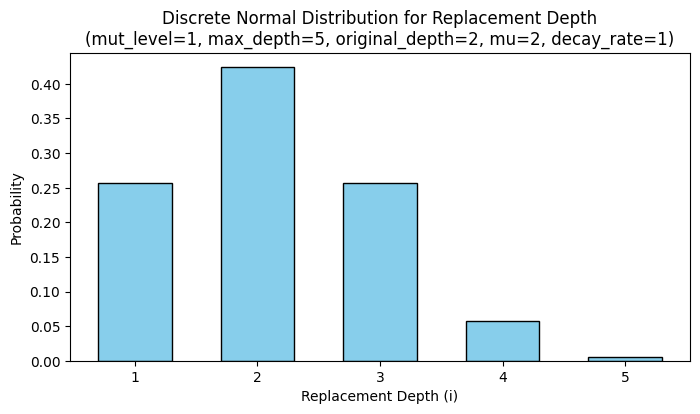

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mut_level = 1
max_depth = 5
d_original = 2
decay_rate = 1
sigma = 1/decay_rate

# Allowed replacement depths range from 1 to max_depth - mut_level + 1
min_depth = 1
max_allowed = max_depth - mut_level + 1  # 10 - 4 + 1 = 7

# Expected replacement depth mu is defined relative to the mutation point:
mu = max(min_depth, min(max_allowed, d_original - mut_level + 1))  # 7 - 4 + 1 = 4

# Define the set of possible replacement depths
depths = np.arange(min_depth, max_allowed + 1)

# Compute the unnormalized probabilities using the discrete normal formula
unnormalized_probs = np.exp(-((depths - mu) ** 2) / (2 * sigma ** 2))

# Normalize the probabilities so that they sum to 1
probs = unnormalized_probs / np.sum(unnormalized_probs)

# Plotting the distribution
plt.figure(figsize=(8, 4))
plt.bar(depths, probs, width=0.6, color='skyblue', edgecolor='black')
plt.xlabel('Replacement Depth (i)')
plt.ylabel('Probability')
plt.title('Discrete Normal Distribution for Replacement Depth\n'
          f'(mut_level={mut_level}, max_depth={max_depth}, original_depth={d_original}, mu={mu}, decay_rate={decay_rate})')
plt.xticks(depths)
plt.show()


In [ ]:
mutator = structure_mutation(FUNCTIONS, TERMINALS, CONSTANTS, mode='exp')
sample_tree = tree
sample_tree.collection[0].depth
print(sample_tree.structure)

fit, depth = [], []
best_fit = np.inf
tree = sample_tree

start = time.time()
for i in range(10000):
    mutated = mutator(tree, X_train, max_depth=8, p_c=0.2, grow_probability=1, decay_rate=0.4, p_t=0.5)
    mutated.evaluate(rmse, y=y_train, operator='sum')
    fit.append(mutated.fitness)
    depth.append(mutated.depth)
    # if mutated.fitness < best_fit:
    #     best_fit = mutated.fitness
    #     tree = mutated

[('multiply', 'constant_0.64', 'x5')]
1.161400318145752


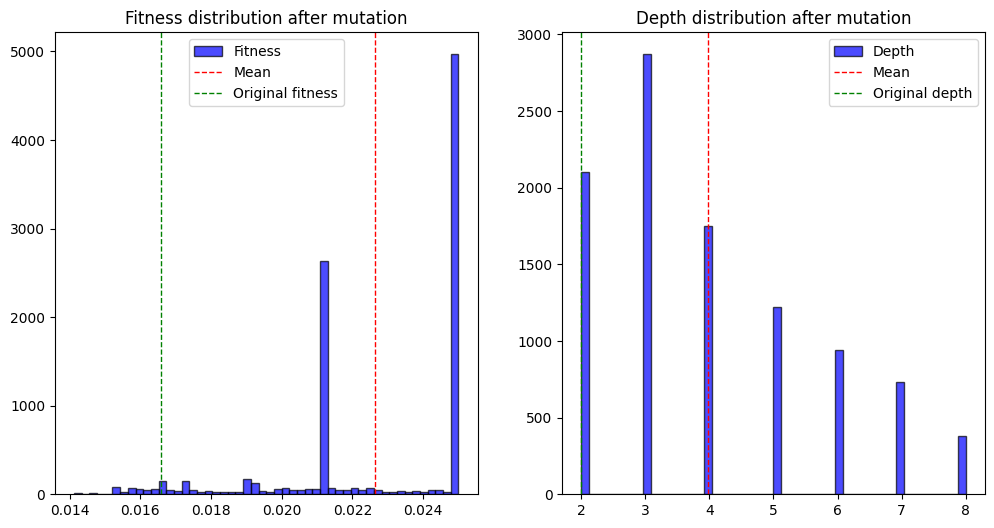

In [1111]:
fit = np.array(fit)
fit = np.clip(fit, -1000, 0.025)

# Plot a histogram of the fitness change and the depth 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(fit, bins=50, color='blue', edgecolor='black', alpha=0.7, label='Fitness')
axs[0].set_title('Fitness distribution after mutation')
axs[0].axvline(np.mean(fit), color='red', linestyle='dashed', linewidth=1, label='Mean')
axs[0].axvline(sample_tree.fitness, color='green', linestyle='dashed', linewidth=1, label='Original fitness')
axs[0].legend()

axs[1].hist(depth, bins=50, color='blue', edgecolor='black', alpha=0.7, label='Depth')
axs[1].set_title('Depth distribution after mutation')
axs[1].axvline(np.mean(depth), color='red', linestyle='dashed', linewidth=1, label='Mean')
axs[1].axvline(sample_tree.collection[0].depth, color='green', linestyle='dashed', linewidth=1, label='Original depth')
axs[1].legend()

plt.show()

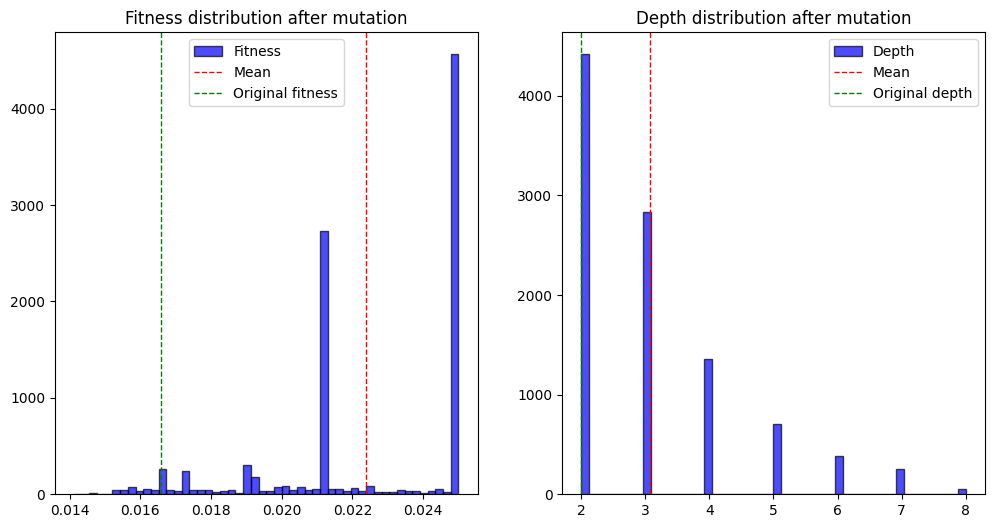

In [1064]:
fit = np.array(fit)
fit = np.clip(fit, -1000, 0.025)

# Plot a histogram of the fitness change and the depth 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(fit, bins=50, color='blue', edgecolor='black', alpha=0.7, label='Fitness')
axs[0].set_title('Fitness distribution after mutation')
axs[0].axvline(np.mean(fit), color='red', linestyle='dashed', linewidth=1, label='Mean')
axs[0].axvline(sample_tree.fitness, color='green', linestyle='dashed', linewidth=1, label='Original fitness')
axs[0].legend()

axs[1].hist(depth, bins=50, color='blue', edgecolor='black', alpha=0.7, label='Depth')
axs[1].set_title('Depth distribution after mutation')
axs[1].axvline(np.mean(depth), color='red', linestyle='dashed', linewidth=1, label='Mean')
axs[1].axvline(sample_tree.collection[0].depth, color='green', linestyle='dashed', linewidth=1, label='Original depth')
axs[1].legend()

plt.show()

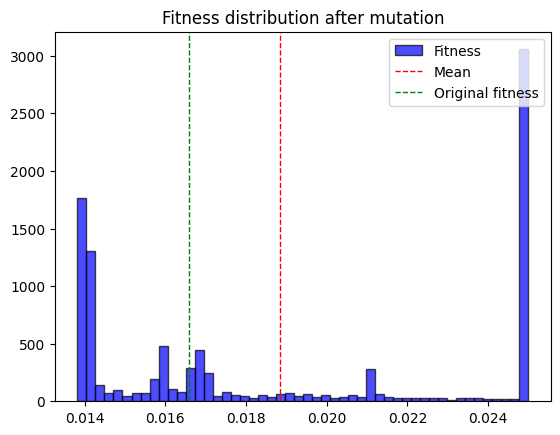

In [994]:
fit = np.array(fit)
fit = np.clip(fit, -1000, 0.025)

# Plot a histogram of the fitness change
plt.hist(fit, bins=50, color='blue', edgecolor='black', alpha=0.7, label='Fitness')
plt.title('Fitness distribution after mutation')
plt.axvline(np.mean(fit), color='red', linestyle='dashed', linewidth=1, label='Mean')   
plt.axvline(sample_tree.fitness, color='green', linestyle='dashed', linewidth=1, label='Original fitness')
plt.legend()
plt.show()

In [ ]:
def analyze_population_quality(dataset, seed, mutation_control_params, 
                              population_size=10000, max_depth=8, 
                              p_c=0.2, p_t=0.8, n_quantiles=5):
    """
    Analyze population quality with controlled mutation rates
    
    Parameters:
    mutation_control_params : dict
        Contains mutation parameters:
        - mutation_prob: Probability of applying mutation [0-1]
        - mutation_strength: Number of mutation operations per individual
        - grow_prob: Probability of grow mutation type
    """
    # Unpack mutation control parameters
    mutation_prob = mutation_control_params.get('mutation_prob', 1.0)
    mutation_strength = mutation_control_params.get('mutation_strength', 1)
    grow_prob = mutation_control_params.get('grow_prob', 0.7)

    # Dataset processing
    X, y = dataset()
    X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)
    
    # Scaler setup
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1)

    # Base tree generation
    base_tree, _ = slim(
        X_train=X_train, y_train=y_train,
        max_depth=17, init_depth=8, pop_size=100,
        p_inflate=0.45, p_struct=0.3, 
        seed=seed, verbose=0
    )
    base_tree = base_tree.collection[0]
    
    # Population initialization with growth control
    population = Population([
        Individual([Tree(base_tree, reconstruct=True)]) 
        for _ in grow(population_size, max_depth, 
                     base_tree.FUNCTIONS, base_tree.TERMINALS, base_tree.CONSTANTS,
                     p_c=p_c, p_t=p_t)
    ])

    # Semantic evaluation pipeline
    population.calculate_semantics(X_train)
    population.evaluate(rmse, y=y_train, operator='sum')

    # Controlled mutation process
    structure_mutator = structure_mutation(
        FUNCTIONS=base_tree.FUNCTIONS,
        TERMINALS=base_tree.TERMINALS,
        CONSTANTS=base_tree.CONSTANTS,
        p_c=mutation_control_params.get('p_c', 0.2),
        depth_dist='exp'
    )

    offs_pop = []
    for ind in population.population:
        if np.random.rand() < mutation_prob:
            for _ in range(mutation_strength):
                ind = structure_mutator(
                    individual=ind,
                    X=X_train,
                    max_depth=max_depth,
                    grow_probability=grow_prob,
                    decay_rate=0.2
                )
        offs_pop.append(ind)

    offs_pop = Population(offs_pop)
    offs_pop.calculate_semantics(X_train)
    offs_pop.evaluate(rmse, y=y_train, operator='sum')

    # Quality analysis
    quantiles = np.linspace(0, 1, n_quantiles+1)[1:-1]
    quality_metrics = {
        'original': np.quantile(population.fit, quantiles),
        'mutated': np.quantile(offs_pop.fit, quantiles)
    }
    
    return quality_metrics

In [ ]:
for i in range(16):
    X,y = datasets[i]()
    X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1)
    tree, _ = slim(X_train=X_train, y_train=y_train, dataset_name='test', test_elite=False, slim_version='SLIM+ABS',
                        max_depth=17, init_depth=8, pop_size=100, n_iter=1, seed=seed, fitness_sharing=False, verbose=0,
                        p_inflate=0.45, p_struct=0.3, struct_mutation=False, full_return=True)

    tree = tree.collection[0]
    CONSTANTS, FUNCTIONS, TERMINALS = tree.CONSTANTS, tree.FUNCTIONS, tree.TERMINALS

    population = Population(
        [
            Individual(
                collection=[
                    Tree(
                        tree,
                        train_semantics=None,
                        test_semantics=None,
                        reconstruct=True,
                    )
                ],
                train_semantics=None,
                test_semantics=None,
                reconstruct=True,
            )
            for tree in grow(10000, 8, FUNCTIONS, TERMINALS, CONSTANTS, p_c=0.2, p_t=0.8)
        ]
    )

    # calculating initial population semantics
    population.calculate_semantics(X_train)
    population.calculate_errors_case(y_train)
    population.evaluate(rmse, y=y_train, operator='sum')

    preds_un = population.train_semantics
    fitness_un = population.fit.copy()

    fitness_sc = []
    preds_sc = []
    fitness_sc_n = []
    for ind in population.population:
        ind.version = 'SLIM+ABS'
        preds = ind.predict(X_train_scaled)
        fitness_sc_n.append(rmse(preds, y_train_scaled))
        # Reverse the scaling
        preds = scaler_y.inverse_transform(preds.reshape(-1,1)).reshape(-1)
        preds_sc.append(preds)
        fitness_sc.append(rmse(preds, y_train))

    threshold_un = np.quantile(fitness_un, 0.25)
    threshold_sc = np.quantile(fitness_sc, 0.25)
    fitness_un_no = [i for i in fitness_un if i < threshold_un]
    fitness_sc_no = [i for i in fitness_sc if i < threshold_sc]
    sns.kdeplot(fitness_un_no, label='Unscaled')
    sns.kdeplot(fitness_sc_no, label='Scaled')
    plt.title(f'Density of fitnesses of GP trees for dataset {i}')
    plt.legend()
    plt.show()

|       test      |       683       |      0.120      |      0.101      |      0.030      |       126       |        22       |      6.960      |      12.500     |     0.63 (9)    |     1.51 (9)    |     0.0 (30)    |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
683 iterations completed. Training stopped by callback.
RMSE: tensor(0.1220, dtype=torch.float64)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.187      |       None      |      0.121      |        3        |     3285198     |      4.520      |      4.520      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

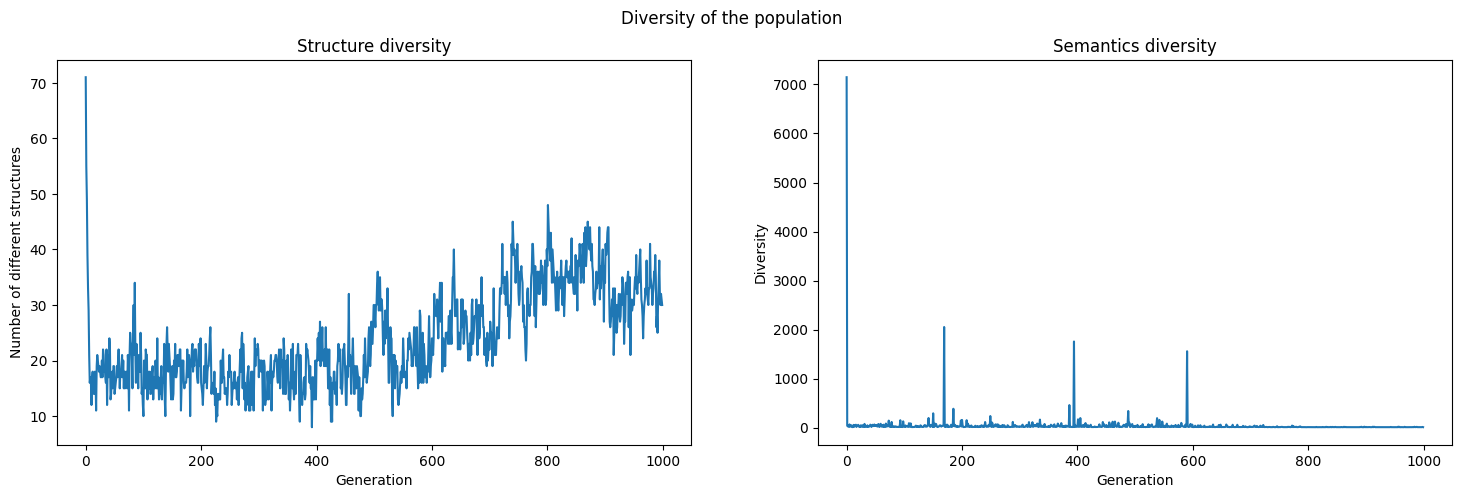

In [ ]:
seed = 10

X,y = datasets[2]()  # AIRFOIL
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)
X_train = torch.tensor(scaler_X.fit_transform(X_train))
y_train = torch.tensor(scaler_y.fit_transform(y_train.reshape(-1,1))).flatten()
X_test = torch.tensor(scaler_X.transform(X_test))
y_test = torch.tensor(scaler_y.transform(y_test.reshape(-1,1))).flatten()

agelog = LogAge()
divlog = LogDiversity()
early_stop = EarlyStopping_train(patience=2500)

example_tree, population = slim(X_train=X_train, y_train=y_train, test_elite=False,
                    dataset_name='test', slim_version='SLIM*ABS',
                    max_depth=17, init_depth=8, pop_size=100, n_iter=1000, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.45, p_struct=0.25, struct_mutation=True, 
                    prob_const=0.2, n_elites=1, selector='tournament', pressure_size=0.5,
                    decay_rate=0.2, p_xo=0, p_struct_xo=0,
                    callbacks=[agelog, divlog, early_stop],
                    depth_distribution='diz', tournament_size=2, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

divlog.plot_diversity()

|       test      |       1000      |      0.116      |       None      |      0.061      |       164       |        7        |      7.960      |      13.010     |    0.73 (13)    |    0.55 (53)    |    0.06 (33)    |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
RMSE: tensor(0.1250, dtype=torch.float64)


|       test      |       1000      |      0.133      |       None      |      0.078      |       196       |        23       |      2.030      |      12.810     |    0.62 (10)    |    0.88 (42)    |    0.18 (47)    |     N/A (0)     |
|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|-----------------|
RMSE: tensor(0.1464, dtype=torch.float64)


In [ ]:
count = 0
for num in population.fit:
    count += num.item()

print('Average fitness:', count/len(population.fit))

Average fitness: 684.4216248960993


In [ ]:
datasets[2]()[0].shape

torch.Size([1503, 5])

In [ ]:
X.shape

torch.Size([100, 1])

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      1.216      |       None      |      0.022      |        3        |        0        |      2.000      |      2.000      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

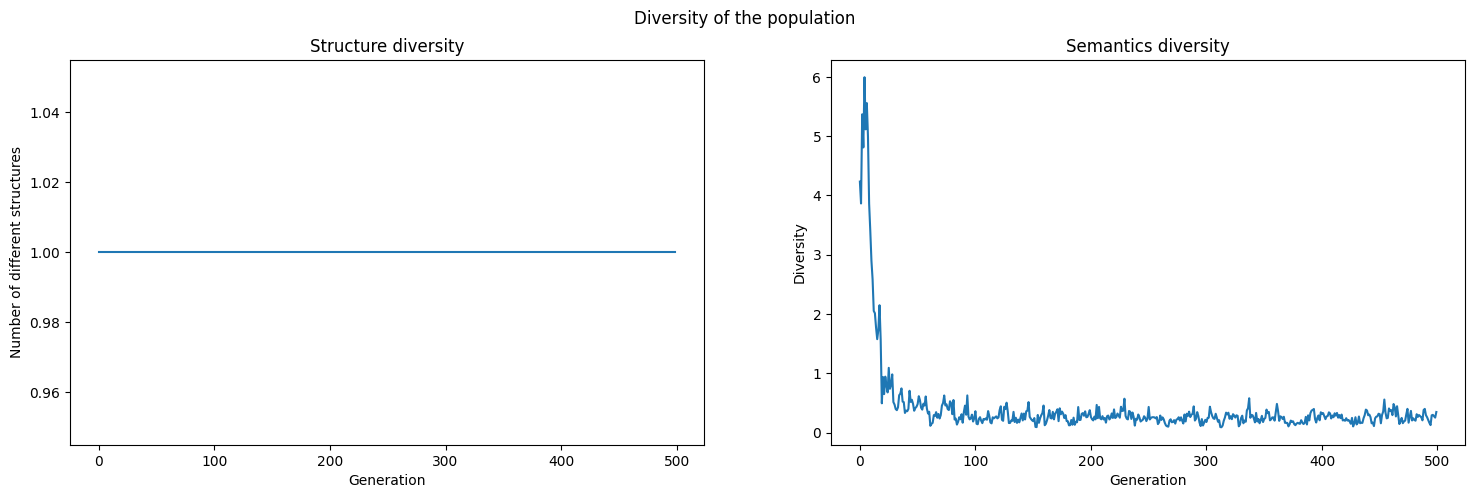

In [ ]:
seed = 50
# Create a mock dataset
X = torch.randn(100, 1) + 2
y = -0.1 * X + torch.randn(100, 1) * 0.1
y = y.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

agelog = LogAge()
divlog = LogDiversity()

example_tree, population = slim(X_train=X_train, y_train=y_train, test_elite=False,
                    dataset_name='test', slim_version='SLIM*SIG1', initializer='simple',
                    max_depth=17, init_depth=8, pop_size=100, n_iter=500, seed=seed, verbose=1,
                    p_inflate=0.5, prob_const=0.20, n_elites=1, selector='tournament',
                    decay_rate=0.12, p_xo=0, p_struct_xo=0, struct_mutation=False,
                    callbacks=[agelog, divlog], ms_lower=0, ms_upper=1,
                    depth_distribution='norm', tournament_size=2, full_return=True, timeout=200,
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

divlog.plot_diversity()

In [ ]:
# Use the 10 best individuals to test the ensemble
best_individuals = sorted(population, key=lambda x: x.fitness)[:1]
ensemble_preds = []
for ind in best_individuals:
    ind.version = example_tree.version
    ensemble_preds.append(ind.predict(X_test))
ensemble_preds = np.array(ensemble_preds)
ensemble_preds = torch.tensor(np.mean(ensemble_preds, axis=0))
print('Ensemble RMSE:', rmse(ensemble_preds, y_test))

Ensemble RMSE: tensor(0.2360)


In [ ]:
seen_semantics = {}
total_mutations = 0
for ind in population.population:
    semantics = ind.train_semantics[1:]
    for sem_ in semantics:
        total_mutations += 1
        sem = sem_[:2]
        sem = sem.tolist()
        sem = str(sem)
        if sem in seen_semantics:
            seen_semantics[sem] += 1
        else:
            seen_semantics[sem] = 1

seen_semantics = {k: v for k, v in sorted(seen_semantics.items(), key=lambda item: item[1], reverse=True)}
seen_semantics

{'[0.7230196215769629, 0.6002229638017295]': 14,
 '[0.24796877708827428, 0.2479687770882788]': 6,
 '[0.30017995673080594, 0.27233717394464]': 4,
 '[0.3187892641318919, 0.45899144458541086]': 4,
 '[0.0020311404438714963, 0.0008681491847771386]': 4,
 '[0.27158352572178357, 0.3533709826224462]': 2,
 '[1.84063092704671e-05, 2.169333863430165e-05]': 2,
 '[-0.07684937859118623, -0.13131736710802744]': 2,
 '[0.044274846711818534, 0.06370220906924576]': 2,
 '[0.0, 0.0]': 2,
 '[0.0004907770662783563, 0.0013050828354391956]': 2,
 '[0.20576008307512586, 0.09953229934861142]': 1,
 '[0.007425623029711139, 0.012889177956393251]': 1,
 '[0.010917039004823563, 0.01626504675423389]': 1,
 '[0.1088245171169006, 0.050542047254475066]': 1,
 '[-0.5512001167212511, -0.8423733538179834]': 1,
 '[0.975037526555191, 0.0]': 1,
 '[-0.0013744028073024487, -0.08114125153987757]': 1,
 '[0.20078269144766503, 0.20482835891112713]': 1,
 '[0.15695009627917758, 0.22653591229798553]': 1,
 '[-0.24889990972506074, -0.41043121

In [ ]:
# Check how many individuals have the most common semantics
most_common_semantics = list(seen_semantics.keys())[0]
count = 0
count_ = 0
for ind in population.population:
    semantics = ind.train_semantics[1:]
    check = True
    for sem_ in semantics:
        sem = sem_[:2]
        sem = sem.tolist()
        sem = str(sem)
        if sem == most_common_semantics:
            count += 1
            break
count

4

In [ ]:
population.population[0].structure

[('multiply',
  ('add',
   ('subtract',
    'constant__0.76',
    ('add', ('multiply', 'constant__0.18', 'constant__0.9'), 'constant_0.05')),
   ('multiply',
    ('add',
     ('divide', ('add', 'x2', 'x4'), ('divide', 'x4', ('divide', 'x3', 'x3'))),
     ('divide', ('add', 'x4', 'constant_0.83'), 'x1')),
    ('multiply', 'x0', 'x4'))),
  'constant__0.67')]

In [ ]:
# Which ones dont have 
for ind in population.population:
    semantics = ind.train_semantics[1:]
    for sem_ in semantics:
        sem = sem_[:5]
        sem = sem.tolist()
        sem = str(sem)
        if sem != most_common_semantics:
            print(sem)
            break

[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[1.1213422461523217, 1.0826020837220371, 1.107485585333633, 1.1092573946161297, 1.0144084577210426]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713]
[0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.5436079502105713, 0.543607950

In [ ]:
preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))
print('Nodes:', example_tree.nodes_count)

example_tree_ = simplify_individual(example_tree, y_val, X_val, threshold=0.05)
preds_ = example_tree_.predict(X_test)
print('RMSE:', rmse(preds_, y_test))
print('Nodes:', example_tree_.nodes_count)

RMSE: tensor(0.1206, dtype=torch.float64)
Nodes: 124
RMSE: tensor(0.1289, dtype=torch.float64)
Nodes: 17


In [ ]:
example_tree_.structure

[(np.str_('divide'),
  ('subtract',
   ('multiply',
    ('add', 'constant_0.4', ('divide', 'x1', 'x2')),
    ('multiply', ('multiply', 'x4', 'x2'), ('divide', 'x0', 'x4'))),
   'constant_0.41'),
  'constant__0.61')]

In [ ]:
pip install tensorflow

In [ ]:
# Try a NN with the same architecture
from keras.models import Sequential 
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(10, input_dim=5, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=250)])
preds = model.predict(X_test)
print('RMSE:', rmse(torch.tensor(preds).flatten(), y_test))

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
struct_mut = structure_mutation(FUNCTIONS=simplified.collection[1].FUNCTIONS, 
                                CONSTANTS=simplified.collection[1].CONSTANTS,
                                TERMINALS=simplified.collection[1].TERMINALS,
                                depth_dist='exp')

rmse_vals = []
size_vals = []
current_best_score = 0.5
current_best = None

for i in range(5000):
    simplified_mut = struct_mut(simplified, X=X_train, max_depth=7, decay_rate=2)
    # simplified_mut = simplify_individual(simplified_mut, y_val, X_val, threshold=0.01)
    simplified_mut.version = simplified.version
    preds_ = simplified_mut.predict(X_test)
    rmse_ = rmse(preds_, y_test)
    if rmse_ < current_best_score:
        current_best_score = rmse_
        current_best = simplified_mut
        print('New best:', rmse_)
        print(simplified_mut.structure[0])
    rmse_vals.append(rmse_)
    size_vals.append(simplified_mut.nodes_collection[0])

New best: tensor(0.4806, dtype=torch.float64)
('multiply', ('add', 'x2', 'x3'), 'constant_0.37')
New best: tensor(0.4568, dtype=torch.float64)
('multiply', ('add', 'x1', ('subtract', 'x1', ('multiply', ('subtract', 'x1', 'x1'), 'x3'))), 'constant_0.37')
New best: tensor(0.3165, dtype=torch.float64)
('multiply', ('add', 'x2', 'x1'), 'constant_0.37')
New best: tensor(0.2693, dtype=torch.float64)
('multiply', ('divide', 'x2', 'x2'), 'constant_0.37')
New best: tensor(0.2232, dtype=torch.float64)
('multiply', ('subtract', 'constant_0.75', 'x4'), 'constant_0.37')
New best: tensor(0.1469, dtype=torch.float64)
('multiply', 'constant_0.7', ('divide', 'constant_0.32', ('divide', 'x0', 'x0')))
New best: tensor(0.1327, dtype=torch.float64)
('multiply', ('divide', 'constant_0.77', 'constant_0.97'), 'constant_0.37')


In [ ]:
preds = current_best.predict(X_test)
print('RMSE:', rmse(preds, y_test))
print('Nodes:', current_best.nodes_count)

current_best_ = simplify_individual(current_best, y_train, X_train, threshold=0.01)
preds_ = current_best_.predict(X_test)
print('RMSE:', rmse(preds_, y_test))
print('Nodes:', current_best_.nodes_count)

RMSE: tensor(0.1280, dtype=torch.float64)
Nodes: 124
RMSE: tensor(0.1280, dtype=torch.float64)
Nodes: 124


RMSE: tensor(0.1158, dtype=torch.float64) </br>
('multiply', 'constant_0.7', ('add', 'x1', 'constant__0.26'))

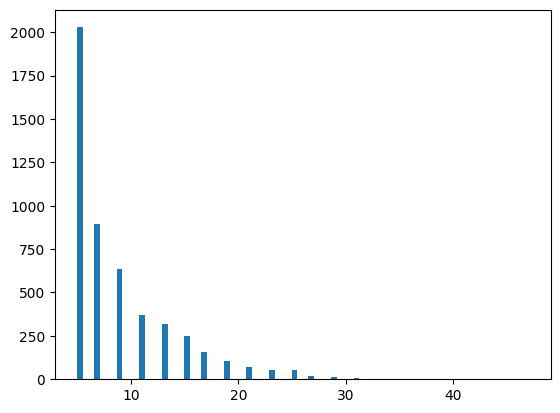

In [ ]:
# Plot the distribution of the size of the trees
plt.hist(size_vals, bins=80)
plt.show()

In [ ]:
np.min(size_vals)

np.int64(5)

In [ ]:
rmse_vals = np.array(rmse_vals)
print('Mean RMSE:', np.min(rmse_vals))
best_id = np.argmin(rmse_vals)
print('Best ID:', best_id)

Mean RMSE: 0.12632628496653595
Best ID: 929


In [ ]:
seed = 0

X,y = datasets[13]()
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = torch.tensor(scaler_X.fit_transform(X))
y = torch.tensor(scaler_y.fit_transform(y.reshape(-1,1)).reshape(-1))
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

agelog = LogAge()
divlog = LogDiversity()

example_tree, population = slim(X_train=X_train, y_train=y_train, # X_test=X_test, y_test=y_test,
                    dataset_name='test', test_elite=False, slim_version='SLIM*SIG1',
                    max_depth=12, init_depth=4, pop_size=20, n_iter=2000, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.4, p_struct=0.2, # selector='e_lexicase',
                    struct_mutation=True, decay_rate=0.1, p_xo=0, type_structure_mutation='new', callbacks=[agelog, divlog],
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.409      |       None      |      0.006      |        3        |       258       |      2.950      |      2.950      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

best 0.243070

In [ ]:
def choose_depth(max_depth, random_index, mean=None, std_dev=None):
    # Calculate the available depths
    depth = max_depth - len(random_index)
    depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
    
    # Set mean and standard deviation
    if mean is None:
        mean = depths.mean()  # Default mean: middle of the range
    if std_dev is None:
        std_dev = (depths[-1] - depths[0]) / 4
    
    # Generate probabilities using the normal distribution formula
    probabilities = np.exp(-((depths - mean) ** 2) / (2 * std_dev ** 2))
    probabilities /= probabilities.sum()  # Normalize
    
    # Choose a depth using the probabilities
    chosen_depth = random.choices(depths, weights=probabilities, k=1)[0]
    
    return chosen_depth

In [ ]:
def choose_depth(max_depth, random_index, mean=None, std_dev=None):
    # Calculate the available depths
    depth = max_depth - len(random_index)
    depths = np.arange(1, depth + 1) if len(random_index) > 1 else np.arange(2, depth + 1)
    
    # Set mean and standard deviation
    if mean is None:
        mean = depths.mean()  # Default mean: middle of the range
    if std_dev is None:
        std_dev = (depths[-1] - depths[0]) / 4
    
    # Generate probabilities using the normal distribution formula
    probabilities = np.exp(-((depths - mean) ** 2) / (2 * std_dev ** 2))
    probabilities /= probabilities.sum()  # Normalize
    
    # Choose a depth using the probabilities
    chosen_depth = random.choices(depths, weights=probabilities, k=1)[0]
    
    return chosen_depth

# Example usage
max_depth = 22
random_index = [1, 2,2,2,2,2]  # Example index

depths = []
for i in range(10000):
    depths.append(choose_depth(max_depth, random_index))
    
plt.hist(depths, bins=np.arange(1, max_depth + 1) - 0.5, rwidth=0.8)
plt.show()

In [ ]:
seed = 0

X,y = datasets[10]()
# Scale
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = torch.tensor(scaler_X.fit_transform(X))
y = torch.tensor(scaler_y.fit_transform(y.reshape(-1,1)).reshape(-1))
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=0.2, seed=seed)

agelog = LogAge()
divlog = LogDiversity()

example_tree, population = slim(X_train=X_train, y_train=y_train, # X_test=X_test, y_test=y_test,
                    dataset_name='test', test_elite=False, slim_version='SLIM*SIG1',
                    max_depth=22, init_depth=10, pop_size=100, n_iter=100, seed=seed, fitness_sharing=False, verbose=1,
                    p_inflate=0.4, p_struct=0.2, selector='e_lexicase',
                    struct_mutation=False, decay_rate=0.1, p_xo=0, type_structure_mutation='new', callbacks=[agelog, divlog],
    )

preds = example_tree.predict(X_test)
print('RMSE:', rmse(preds, y_test))

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|     dataset     |        it       |      train      |       test      |       time      |      nodes      |       div       |     avgStru     |      avgDep     |      struct     |     inflate     |     deflate     |        xo       |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|       test      |        0        |      0.234      |       None      |      0.213      |        3        |    2128770183   |      4.910      |      4.910      |     N/A (0)     |     N/A (0)     |     N/A (0)     |     N/A (0)     |
|-----------------|-----------------|-----------------|-

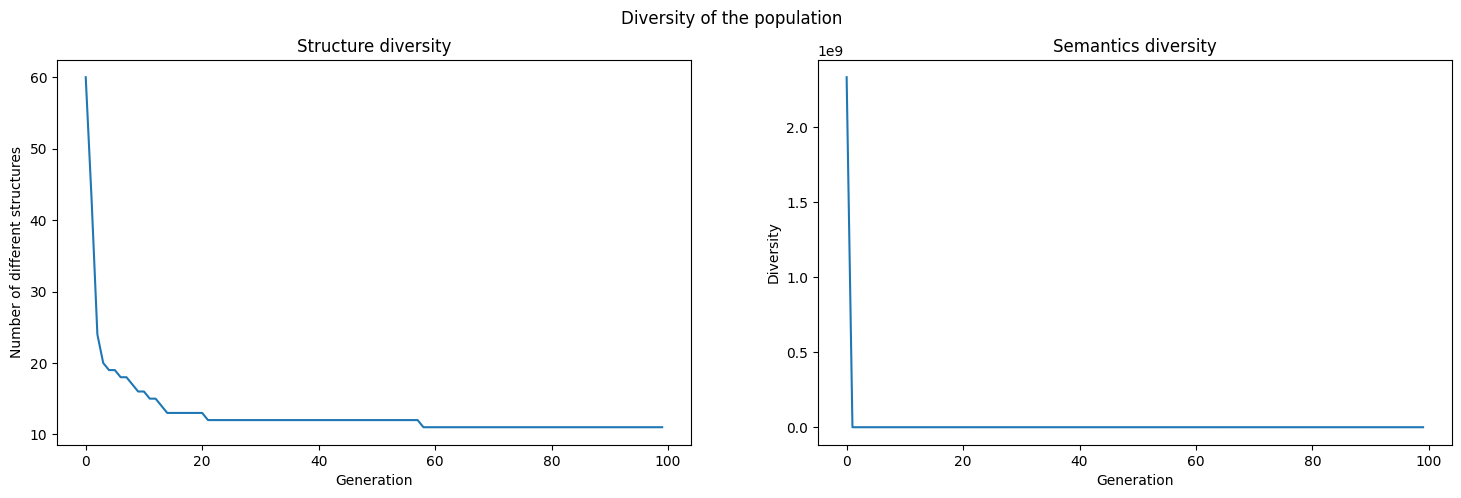

In [ ]:
divlog.plot_diversity()

In [ ]:
# Check the fitness for each individual
fitnesses = []

for tree in population.population:
    preds = tree.predict(X_test)
    fitnesses.append(rmse(preds, y_test))

# Get the 10 best fitnesses from the fitnesses list 
best_fitnesses = sorted(fitnesses)[:10]

# Get the ids 
best_ids = [fitnesses.index(i) for i in best_fitnesses]

ten_best = [population.population[i] for i in best_ids]

# Create a dataset and predict a linear model for the stacking ensemble
X_train_stacking = torch.zeros((X_train.shape[0], size))
X_test_stacking = torch.zeros((X_test.shape[0], size))

for i, tree in enumerate(ten_best):
    tree.version = 'SLIM*SIG1'
    X_train_stacking[:, i] = tree.predict(X_train)
    X_test_stacking[:, i] = tree.predict(X_test)
    
# Train a linear model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_stacking, y_train)

preds = lr.predict(X_test_stacking)
print('RMSE:', rmse(torch.tensor(preds), y_test))

RMSE: tensor(0.1013, dtype=torch.float64)


In [ ]:
constants = example_tree.collection[0].CONSTANTS
functions = example_tree.collection[0].FUNCTIONS
terminals = example_tree.collection[0].TERMINALS
depths = []

for i in range(10000):
    dep = choose_depth(14, [1,1,1,1])
    # dep = random.choice(np.arange(1, 14 + 1))
    # probs = exp_decay_prob(14, 0.3)
    # dep = random.choices(np.arange(1, 14 + 1), weights=probs, k=1)[0]
    if dep == 1:
        depths.append(1)
    else:
        depth = get_random_tree(max_depth=dep, 
                        FUNCTIONS=functions,
                        TERMINALS=terminals,
                        CONSTANTS=constants,
                        p_c=0.1).depth
        
        depths.append(depth)

plt.hist(depths, bins=np.arange(1, 14 + 1) - 0.5, rwidth=0.8)
plt.show()

In [ ]:
indices_with_levels = get_indices_with_levels(example_tree.structure[0])
valid_indices_with_levels = [(index, level) for index, level in indices_with_levels if 22 - len(index) >= 2]


valid_indices, valid_levels = zip(*valid_indices_with_levels)
probs = exp_decay_prob(max(valid_levels) + 1, decay_rate=0.2)
level_probs = [probs[level] for level in valid_levels]
random_index = random.choices(valid_indices, weights=level_probs)[0]

In [ ]:
indices_list = get_indices_with_levels(example_tree.structure[0])

In [ ]:
get_indices_with_levels(example_tree.structure[0])

In [ ]:
exp_decay_prob(5, decay_rate=0.3)

In [ ]:
decay_prob

In [ ]:
counts_dict = {}

for i in range(10000):
    random_index = random.choices(indices_list, weights=decay_prob)[0]
    if random_index in counts_dict:
        counts_dict[random_index] += 1
    else:
        counts_dict[random_index] = 1

In [ ]:
counts_dict